In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize
from skopt.space import Integer, Real

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, return_hilbert_x0
from tools.ae_v2 import Autoencoder
from tools.GRU_SingleStep_v1 import RNN_GRU
from tools.GRU_AR_v1 import AR_RNN_GRU
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.hyper_param_GRU import trainGRU_and_return_PH

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-01 01:05:26.801709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 01:05:26.801952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 01:05:26.839607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 01:05:26.839861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-01 01:05:26.840060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
# from numpy import *

# making RNN save directory
dir_name_rnn = os.getcwd() + dir_sep + 'GRU_params_Search'
if not os.path.isdir(dir_name_rnn):
    os.makedirs(dir_name_rnn)

counter = 0
while True:
    dir_check = 'params_search_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_rnn = dir_name_rnn + dir_sep + dir_check
os.makedirs(dir_name_rnn)
dir_name_rnn_plots = dir_name_rnn+dir_sep+'plots'
os.makedirs(dir_name_rnn_plots)

# whether to use AE data or just work on raw data
use_ae_data = True # if false, specifying ae_idx will only show which dataset to use

# autoencoder directory
# ae_idx = '046'
# dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_'.format(ds=dir_sep)+ae_idx
dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_024'.format(ds=dir_sep)

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [14]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [15]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[      0 4200001]


In [16]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [17]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [18]:
all_data = all_data[0:new_bia[-1]]

In [19]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [20]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

time_stddev_ogdata = np.std(all_data[:, 0:og_vars], axis=0)
time_mean_ogdata = np.mean(all_data[:, 0:og_vars], axis=0)
    
if use_ae_data == True:
    if ae_data_with_params == True and alldata_withparams_flag == False:
        new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
        new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
        del(all_data)
        all_data = new_all_data
        prev_idx = 0
        for i in range(boundary_idx_arr.shape[0]):
            all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
            prev_idx = boundary_idx_arr[i]

    if normalizeforae_flag == True:
        for i in range(all_data.shape[1]):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:og_vars]

# Autoencoder

In [21]:
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [22]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [23]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    # del(all_data)
else:
    latent_states_all = all_data
num_latent_states = latent_states_all.shape[1]

In [24]:
print(latent_states_all.shape)

(4200001, 2)


# GRU

In [25]:
# RNN data parameters
num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
dt_rnn = 0.1
T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
T_offset = dt_rnn
normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
normalization_arr = None
skip_intermediate = 'full sample'
noise_type = 'normal' # can be 'uniform' or 'normal'

# can be 'minmax', 'minmax2', 'stddev', or a list with
# sequential order of any of these; if it is 'minmax'
# then stddev_multiplier has no effect
normalization_type = 'stddev'
stddev_multiplier = 3

dense_layer_act_func = ['tanh']
use_weights_post_dense = True
stateful = True
use_learnable_state = False
use_trainable_weights_with_reslayers = False

if return_params_arr != False:
    params = params_arr
else:
    params = None

scalar_weights = None
num_layers = 1
if not isinstance(scalar_weights, type(None)):
    num_layers += int(((8*len(scalar_weights)+1)**0.5 - 1)/2)
rnn_layers_units = [20*num_latent_states]*num_layers
    
zoneout_x0 = 0.00
vary_zoneout = False


if return_params_arr != False:
    params = params_arr
else:
    params = None

# saving simulation data
sim_data = {
    'params_mat':params_mat,
    'init_state_mat':init_state_mat,
    't0':t0,
    'T':T,
    'delta_t':delta_t,
    'return_params_arr':return_params_arr,
    'dir_name_ae':dir_name_ae,
    'normalize_dataset':normalize_dataset,
    'stddev_multiplier':stddev_multiplier,
    'use_ae_data':use_ae_data,
}

# saving RNN specific data
RNN_specific_data = {    
    'dt_rnn':dt_rnn,
    'T_sample_input':T_sample_input,
    'T_sample_output':T_sample_output,
    'T_offset':T_offset,
    'boundary_idx_arr':boundary_idx_arr,
    'delta_t':delta_t,
    'params':params,
    'return_params_arr':return_params_arr,
    'normalize_dataset':normalize_dataset,
    'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
    'stddev_multiplier':stddev_multiplier,
    'skip_intermediate':skip_intermediate,
    'module':RNN_GRU.__module__,
    'noise_type':noise_type,
    'normalization_type':normalization_type,
    'dense_layer_act_func':dense_layer_act_func,
    'stateful':stateful,
    'use_learnable_state':use_learnable_state,
    'use_weights_post_dense':use_weights_post_dense,
    'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
}

In [26]:
# latent_states_all = latent_states_all[0:375009]
# boundary_idx_arr = [375009]

In [27]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [28]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [29]:
rnn_res_dict = create_data_for_RNN(
    all_data,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=False,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type,
    FTYPE=FTYPE,
    ITYPE=ITYPE)
    
AR_data_rnn_input = rnn_res_dict['data_rnn_input']
AR_data_rnn_output = rnn_res_dict['data_rnn_output']
AR_org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
AR_org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
AR_num_samples = rnn_res_dict['num_samples']
AR_normalization_arr = rnn_res_dict['normalization_arr']
AR_rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

del(AR_org_data_idx_arr_input)
del(AR_org_data_idx_arr_output)
del(AR_rnn_data_boundary_idx_arr)

del(all_data)

In [30]:
print(data_rnn_input.shape)

(7500, 55, 2)


In [31]:
# setting up training params
learning_rate_list = [1e-2, 1e-3, 1e-4]#, 1e-5]
epochs = 125
patience = 10 # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 32
rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

lambda_reg_x0 = 1e-7 # weight for regularizer
fRMS_x0 = 1e-3

rnncell_dropout_rate = 0.0
denselayer_dropout_rate = 0.0

# ph computation parameters
num_runs = 25
T_sample_input_AR_ratio = 1
T_sample_output_AR_ratio = 2

# saving training params
training_specific_params = {
    'epochs':epochs,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'fRMS':fRMS,
    'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
    # 'stddev':stddev,
    # 'lambda_reg':lambda_reg,
    'min_delta':min_delta,
    'patience':patience,
    'rnncell_dropout_rate':rnncell_dropout_rate,
    'denselayer_dropout_rate':denselayer_dropout_rate,
}

In [32]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * int( np.round(train_split*num_samples/batch_size) )
    num_val_arr[i] = batch_size * int( np.round(val_split*num_samples/batch_size) )
    num_test_arr[i] = batch_size * int( np.round((num_samples - num_train_arr[i] - num_val_arr[i])/batch_size) )
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape, dtype=FTYPE)
training_data_rnn_output = np.empty(shape=training_output_shape, dtype=FTYPE)

val_data_rnn_input = np.empty(shape=val_input_shape, dtype=FTYPE)
val_data_rnn_output = np.empty(shape=val_output_shape, dtype=FTYPE)

testing_data_rnn_input = np.empty(shape=testing_input_shape, dtype=FTYPE)
testing_data_rnn_output = np.empty(shape=testing_output_shape, dtype=FTYPE)

AR_testing_data_rnn_input = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)
AR_testing_data_rnn_output = np.empty(shape=tuple(testing_input_shape[0:2])+tuple(AR_data_rnn_input.shape[2:]), dtype=FTYPE)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( np.round(train_split*num_samples/batch_size) )*batch_size
    # num_val = int( np.round(val_split*num_samples/batch_size) )*batch_size
    
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        
        AR_testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        AR_testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = AR_data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)
del(AR_data_rnn_input)
del(AR_data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [33]:
s_in = AR_testing_data_rnn_input.shape
AR_testing_data_rnn_input = AR_testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])

s_out = AR_testing_data_rnn_output.shape
AR_testing_data_rnn_output = AR_testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])

T_sample_input_AR = T_sample_input_AR_ratio*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = T_sample_output_AR_ratio*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
maxpossible_num_runs = AR_testing_data_rnn_input.shape[1]-(num_sample_input_AR+num_sample_output_AR)

num_runs = np.min([num_runs, maxpossible_num_runs])

print('num_runs : ', num_runs)

data_idx_arr = np.linspace(0, maxpossible_num_runs-1, num_runs, dtype=np.int32)

num_runs :  25


In [34]:
AR_data_in = np.empty(shape=(num_runs, num_sample_input_AR)+tuple(s_in[2:]))
AR_data_out = np.empty(shape=(num_runs, num_sample_output_AR)+tuple(s_out[2:]))

for i in range(num_runs):
    d_idx = data_idx_arr[i]
    AR_data_in[i] = AR_testing_data_rnn_input[0, d_idx:d_idx+num_sample_input_AR]
    AR_data_out[i] = AR_testing_data_rnn_input[0, d_idx+num_sample_input_AR:d_idx+num_sample_input_AR+num_sample_output_AR]

In [35]:
del(AR_testing_data_rnn_input)
del(AR_testing_data_rnn_output)
AR_testing_data_rnn_input = AR_data_in
AR_testing_data_rnn_output = AR_data_out

In [36]:
print('   training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print('  training_data_rnn_output.shape : ', training_data_rnn_output.shape)
print('    testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('   testing_data_rnn_output.shape : ', testing_data_rnn_output.shape)
print('        val_data_rnn_input.shape : ', val_data_rnn_input.shape)
print('       val_data_rnn_output.shape : ', val_data_rnn_output.shape)
print('')
print(' AR_testing_data_rnn_input.shape : ', AR_testing_data_rnn_input.shape)
print('AR_testing_data_rnn_output.shape : ', AR_testing_data_rnn_output.shape)

   training_data_rnn_input.shape :  (6016, 55, 2)
  training_data_rnn_output.shape :  (6016, 55, 2)
    testing_data_rnn_input.shape :  (736, 55, 2)
   testing_data_rnn_output.shape :  (736, 55, 2)
        val_data_rnn_input.shape :  (736, 55, 2)
       val_data_rnn_output.shape :  (736, 55, 2)

 AR_testing_data_rnn_input.shape :  (25, 11, 3)
AR_testing_data_rnn_output.shape :  (25, 22, 3)


In [37]:
training_data_rnn_input.dtype

dtype('float32')

In [38]:
def optim_func(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev=time_stddev,
        og_vars=og_vars,
        RNN_GRU=RNN_GRU,
        AR_RNN_GRU=AR_RNN_GRU,
        AR_AERNN_GRU=AR_AERNN_GRU,
        ae_net=ae_net,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        dir_name_rnn=dir_name_rnn,
        boundary_idx_arr=rnn_data_boundary_idx_arr,
        lyapunov_time_arr=lyapunov_time_arr,
        sim_data_dict=sim_data,
        RNN_specific_data_dict=RNN_specific_data,
        training_specific_params_dict=training_specific_params,
        normalization_arr=normalization_arr,
        training_data_rnn_input=training_data_rnn_input,
        training_data_rnn_output=training_data_rnn_output,
        testing_data_rnn_input=testing_data_rnn_input,
        testing_data_rnn_output=testing_data_rnn_output,
        val_data_rnn_input=val_data_rnn_input,
        val_data_rnn_output=val_data_rnn_output,
        AR_testing_data_rnn_input=AR_testing_data_rnn_input,
        AR_testing_data_rnn_output=AR_testing_data_rnn_output,
        return_params_arr=return_params_arr,
        normalize_dataset=normalize_dataset,
        dt_rnn=dt_rnn,
        noise_type=noise_type,
        ae_data_normalization_arr=normalization_constant_arr_aedata,
        time_stddev_ogdata=time_stddev_ogdata,
        time_mean_ogdata=time_mean_ogdata,
        T_sample_input=T_sample_input_AR,
        T_sample_output=T_sample_output_AR,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name='L2',
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        zoneout=zoneout_x0,
    ):
    
    compute_time = time.time()
    
    x = [elem for elem in np.array(x).flatten()]
    if len(x) < 3:
        x.append(zoneout)

    median_PH = trainGRU_and_return_PH(
        x, # [fRMS, lambda_reg, zoneout]
        time_stddev,
        og_vars,
        RNN_GRU,
        AR_RNN_GRU,
        AR_AERNN_GRU,
        ae_net,
        mytimecallback,
        SaveLosses,
        plot_losses,
        dir_name_rnn,
        boundary_idx_arr,
        lyapunov_time_arr,
        sim_data_dict,
        RNN_specific_data_dict,
        training_specific_params_dict,
        normalization_arr,
        training_data_rnn_input,
        training_data_rnn_output,
        testing_data_rnn_input,
        testing_data_rnn_output,
        val_data_rnn_input,
        val_data_rnn_output,
        AR_testing_data_rnn_input,
        AR_testing_data_rnn_output,
        return_params_arr,
        normalize_dataset,
        dt_rnn,
        noise_type,
        ae_data_normalization_arr,
        time_stddev_ogdata,
        time_mean_ogdata,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output,
        rnn_layers_units=rnn_layers_units,
        stateful=stateful,
        reg_name=reg_name,
        dense_layer_act_func=dense_layer_act_func,
        use_learnable_state=use_learnable_state,
        use_weights_post_dense=use_weights_post_dense,
        rnncell_dropout_rate=rnncell_dropout_rate,
        denselayer_dropout_rate=denselayer_dropout_rate,
        scalar_weights=scalar_weights,
        prng_seed=prng_seed,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        error_threshold=0.5,
        xlabel_kwargs={'fontsize':15},
        ylabel_kwargs={'fontsize':15},
        legend_kwargs={'fontsize':12},
    )
    
    compute_time = time.time() - compute_time
    print('compute_time : {:.0f}h {:.0f}m {:.0f}s'.format(
        float(compute_time // 3600),
        float((compute_time%3600)//60),
        float((compute_time%3600)%60),
    ))
    
    return -median_PH

In [39]:
x_bounds = [
    [1e-4, 1e-1, "log-uniform", "Real"], # fRMS
    [1e-7, 1e-3, "log-uniform", "Real"], # lambda_reg
]
if vary_zoneout == True:
    x_bounds.append([0.0, 0.5, "uniform", "Real"])

In [40]:
h_dims = len(x_bounds)
# num_points = 10*h_dims
num_points = 20

h_order = 0
while(True):
    if 2**(h_dims*h_order) >= num_points:
        break
    else:
        h_order += 1

print('h_dims : {} ; num_points : {} ; h_order : {}'.format(h_dims, num_points, h_order))

h_dims : 2 ; num_points : 20 ; h_order : 3


In [41]:
locs = return_hilbert_x0(num_points, h_dims, h_order)
# print(locs)
locs = np.array(locs, dtype=np.float64)
locs /= 2**h_order-1
# print(locs)

for i in range(h_dims):
    x1 = x_bounds[i][0]
    x2 = x_bounds[i][1]
    if x_bounds[i][2] == "log-uniform":
        x1 = np.log10(x1)
        x2 = np.log10(x2)
    spread = x2 - x1
    locs[:, i] *= spread
    locs[:, i] += x1
    if x_bounds[i][2] == "log-uniform":
        locs[:, i] = 10**(locs[:, i])

# print(locs)

In [42]:
dimensions = [
    eval(elem[3])(*elem[0:3]) for elem in x_bounds
]

In [43]:
print(locs)

x0 = [
    [elem2 for elem2 in elem1] for elem1 in locs
]

print(x0)

[[1.00000000e-04 1.00000000e-07]
 [2.68269580e-04 1.00000000e-07]
 [1.93069773e-03 3.72759372e-07]
 [1.93069773e-03 1.38949549e-06]
 [2.68269580e-04 5.17947468e-06]
 [1.00000000e-04 1.93069773e-05]
 [1.00000000e-04 7.19685673e-05]
 [2.68269580e-04 1.00000000e-03]
 [7.19685673e-04 1.00000000e-03]
 [1.93069773e-03 7.19685673e-05]
 [5.17947468e-03 1.93069773e-05]
 [5.17947468e-03 7.19685673e-05]
 [1.38949549e-02 1.00000000e-03]
 [3.72759372e-02 1.00000000e-03]
 [1.00000000e-01 7.19685673e-05]
 [1.00000000e-01 5.17947468e-06]
 [3.72759372e-02 5.17947468e-06]
 [5.17947468e-03 1.38949549e-06]
 [5.17947468e-03 3.72759372e-07]
 [3.72759372e-02 1.00000000e-07]]
[[0.0001, 1e-07], [0.00026826957952797245, 1e-07], [0.0019306977288832496, 3.727593720314938e-07], [0.0019306977288832496, 1.389495494373136e-06], [0.00026826957952797245, 5.179474679231212e-06], [0.0001, 1.9306977288832496e-05], [0.0001, 7.196856730011529e-05], [0.00026826957952797245, 0.001], [0.0007196856730011522, 0.001], [0.00193069

In [44]:
acq_func = "EI"
n_initial_points = 0
n_calls = n_initial_points + len(x0) + 10

In [45]:
optim_dict = {
    'fRMS_bounds':x_bounds[0],
    'lambda_reg_bounds':x_bounds[1],
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
    'vary_zoneout':vary_zoneout,
}
if vary_zoneout == True:
    optim_dict['zoneout_bounds'] = x_bounds[2]
with open(dir_name_rnn + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [46]:
res = gp_minimize(
    optim_func,
    dimensions,
    x0=x0,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0109 - mse: 0.0109 - NMSE: 0.0982 - tot_time: 0h 0m 11.1s

Epoch 1: val_NMSE improved from inf to 0.00934, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 49ms/step - loss: 0.0109 - mse: 0.0109 - NMSE: 0.0982 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0093
Epoch 2/125
187/188 [============================>.] - ETA: 0s - loss: 6.8255e-04 - mse: 6.21

Epoch 13/125
188/188 [==============================] - ETA: 0s - loss: 1.8571e-04 - mse: 1.1900e-04 - NMSE: 0.0011 - tot_time: 0h 1m 57.4s

Epoch 13: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.8571e-04 - mse: 1.1900e-04 - NMSE: 0.0011 - val_loss: 1.9180e-04 - val_mse: 1.2547e-04 - val_NMSE: 0.0011
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 1.7080e-04 - mse: 1.0490e-04 - NMSE: 9.4816e-04 - tot_time: 0h 2m 6.2s

Epoch 14: val_NMSE improved from 0.00102 to 0.00083, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.3125e-04 - mse: 7.5870e-05 - NMSE: 6.8578e-04 - val_loss: 1.1887e-04 - val_mse: 6.3817e-05 - val_NMSE: 5.7684e-04
Epoch 28/125
187/188 [============================>.] - ETA: 0s - loss: 1.2525e-04 - mse: 7.0516e-05 - NMSE: 6.3738e-04 - tot_time: 0h 4m 9.6s

Epoch 28: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.2520e-04 - mse: 7.0466e-05 - NMSE: 6.3692e-04 - val_loss: 1.7494e-04 - val_mse: 1.2064e-04 - val_NMSE: 0.0011
Epoch 29/125
187/188 [============================>.] - ETA: 0s - loss: 1.1122e-04 - mse: 5.7243e-05 - NMS

Epoch 42/125
187/188 [============================>.] - ETA: 0s - loss: 1.5932e-04 - mse: 1.1254e-04 - NMSE: 0.0010 - tot_time: 0h 6m 12.1s

Epoch 42: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.5884e-04 - mse: 1.1206e-04 - NMSE: 0.0010 - val_loss: 9.4894e-05 - val_mse: 4.7958e-05 - val_NMSE: 4.3350e-04
Epoch 43/125
187/188 [============================>.] - ETA: 0s - loss: 9.9480e-05 - mse: 5.2801e-05 - NMSE: 4.7722e-04 - tot_time: 0h 6m 20.8s

Epoch 43: val_NMSE improved from 0.00043 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn

Epoch 56/125
187/188 [============================>.] - ETA: 0s - loss: 1.0057e-04 - mse: 6.0308e-05 - NMSE: 5.4513e-04 - tot_time: 0h 8m 16.8s

Epoch 56: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 1.0130e-04 - mse: 6.1036e-05 - NMSE: 5.5172e-04 - val_loss: 2.4244e-04 - val_mse: 2.0245e-04 - val_NMSE: 0.0018
Epoch 57/125
187/188 [============================>.] - ETA: 0s - loss: 8.6334e-05 - mse: 4.6523e-05 - NMSE: 4.2051e-04 - tot_time: 0h 8m 25.8s

Epoch 57: val_NMSE did not improve from 0.00037
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 8.6252e-05 - mse: 4.6443e-05

Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 5.2346e-05 - mse: 1.5524e-05 - NMSE: 1.4033e-04 - tot_time: 0h 12m 33.8s

Epoch 14: val_NMSE did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 5.2346e-05 - mse: 1.5524e-05 - NMSE: 1.4033e-04 - val_loss: 6.8527e-05 - val_mse: 3.1773e-05 - val_NMSE: 2.8720e-04
Epoch 15/125
188/188 [==============================] - ETA: 0s - loss: 5.1923e-05 - mse: 1.5230e-05 - NMSE: 1.3767e-04 - tot_time: 0h 12m 42.6s

Epoch 15: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 38/125
187/188 [============================>.] - ETA: 0s - loss: 4.5384e-05 - mse: 1.2076e-05 - NMSE: 1.0916e-04 - tot_time: 0h 16m 5.1s

Epoch 38: val_NMSE did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.5371e-05 - mse: 1.2063e-05 - NMSE: 1.0905e-04 - val_loss: 5.8228e-05 - val_mse: 2.4977e-05 - val_NMSE: 2.2575e-04
Epoch 39/125
187/188 [============================>.] - ETA: 0s - loss: 4.5261e-05 - mse: 1.2057e-05 - NMSE: 1.0899e-04 - tot_time: 0h 16m 13.7s

Epoch 39: val_NMSE did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.5248e-05 - mse: 1.204

Epoch 7/125
187/188 [============================>.] - ETA: 0s - loss: 4.3200e-05 - mse: 9.7152e-06 - NMSE: 8.7821e-05 - tot_time: 0h 18m 8.8s

Epoch 7: val_NMSE improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_000/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.3192e-05 - mse: 9.7069e-06 - NMSE: 8.7746e-05 - val_loss: 5.7734e-05 - val_mse: 2.4259e-05 - val_NMSE: 2.1926e-04
Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 4.3176e-05 - mse: 9.7091e-06 - NMSE: 8.7765e-05 - tot_time: 0h 18m 17.5s

Epoch 8: val_NMSE improved from 0.00022 to 0.00022, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/teste

Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 1.5584e-04 - mse: 9.3260e-05 - NMSE: 8.4298e-04 - tot_time: 0h 2m 53.0s

Epoch 18: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.5584e-04 - mse: 9.3260e-05 - NMSE: 8.4298e-04 - val_loss: 1.9043e-04 - val_mse: 1.2831e-04 - val_NMSE: 0.0012
Epoch 19/125
187/188 [============================>.] - ETA: 0s - loss: 1.6012e-04 - mse: 9.8283e-05 - NMSE: 8.8839e-04 - tot_time: 0h 3m 2.2s

Epoch 19: val_NMSE improved from 0.00075 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 32/125
187/188 [============================>.] - ETA: 0s - loss: 1.1612e-04 - mse: 6.3318e-05 - NMSE: 5.7232e-04 - tot_time: 0h 4m 56.6s

Epoch 32: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.1623e-04 - mse: 6.3432e-05 - NMSE: 5.7335e-04 - val_loss: 1.6698e-04 - val_mse: 1.1459e-04 - val_NMSE: 0.0010
Epoch 33/125
188/188 [==============================] - ETA: 0s - loss: 1.2138e-04 - mse: 6.9272e-05 - NMSE: 6.2614e-04 - tot_time: 0h 5m 5.5s

Epoch 33: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.2138e-04 - mse: 6.9272e-05 

Epoch 46/125
188/188 [==============================] - ETA: 0s - loss: 1.0204e-04 - mse: 5.7841e-05 - NMSE: 5.2285e-04 - tot_time: 0h 7m 1.8s

Epoch 46: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.0204e-04 - mse: 5.7841e-05 - NMSE: 5.2285e-04 - val_loss: 9.6593e-05 - val_mse: 5.2665e-05 - val_NMSE: 4.7600e-04
Epoch 47/125
188/188 [==============================] - ETA: 0s - loss: 9.6040e-05 - mse: 5.2255e-05 - NMSE: 4.7231e-04 - tot_time: 0h 7m 10.5s

Epoch 47: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.6040e-05 - mse: 5.2255e

Epoch 61/125
188/188 [==============================] - ETA: 0s - loss: 8.5477e-05 - mse: 4.7602e-05 - NMSE: 4.3027e-04 - tot_time: 0h 9m 14.2s

Epoch 61: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 8.5477e-05 - mse: 4.7602e-05 - NMSE: 4.3027e-04 - val_loss: 7.9019e-05 - val_mse: 4.1435e-05 - val_NMSE: 3.7452e-04
Epoch 62/125
187/188 [============================>.] - ETA: 0s - loss: 7.6571e-05 - mse: 3.9162e-05 - NMSE: 3.5397e-04 - tot_time: 0h 9m 22.8s

Epoch 62: val_NMSE did not improve from 0.00031
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 7.6550e-05 - mse: 3.9142

Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 4.9588e-05 - mse: 1.2918e-05 - NMSE: 1.1678e-04 - tot_time: 0h 11m 17.7s

Epoch 2: val_NMSE improved from 0.00025 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.9588e-05 - mse: 1.2918e-05 - NMSE: 1.1678e-04 - val_loss: 6.3482e-05 - val_mse: 2.6880e-05 - val_NMSE: 2.4296e-04
Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 4.9210e-05 - mse: 1.2680e-05 - NMSE: 1.1462e-04 - tot_time: 0h 11m 26.6s

Epoch 3: val_NMSE improved from 0.00024 to 0.00024, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/test

Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 4.7816e-05 - mse: 1.3313e-05 - NMSE: 1.2035e-04 - tot_time: 0h 13m 21.1s

Epoch 16: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.7816e-05 - mse: 1.3313e-05 - NMSE: 1.2035e-04 - val_loss: 6.0728e-05 - val_mse: 2.6308e-05 - val_NMSE: 2.3779e-04
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 4.7571e-05 - mse: 1.3221e-05 - NMSE: 1.1951e-04 - tot_time: 0h 13m 29.8s

Epoch 17: val_NMSE improved from 0.00024 to 0.00023, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.4627e-05 - mse: 1.2011e-05 - NMSE: 1.0858e-04 - val_loss: 5.6798e-05 - val_mse: 2.4261e-05 - val_NMSE: 2.1928e-04
Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 4.4356e-05 - mse: 1.1884e-05 - NMSE: 1.0742e-04 - tot_time: 0h 15m 15.9s

Epoch 29: val_NMSE did not improve from 0.00022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.4356e-05 - mse: 1.1884e-05 - NMSE: 1.0742e-04 - val_loss: 5.6667e-05 - val_mse: 2.4271e-05 - val_NMSE: 2.1937e-04
Epoch 30/125
188/188 [==============================] - ETA: 0s - loss: 4.4119e-05 - mse: 1.1786e-05

Epoch 4/125
187/188 [============================>.] - ETA: 0s - loss: 4.2136e-05 - mse: 9.6534e-06 - NMSE: 8.7263e-05 - tot_time: 0h 17m 11.2s

Epoch 4: val_NMSE did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.2130e-05 - mse: 9.6483e-06 - NMSE: 8.7217e-05 - val_loss: 5.6153e-05 - val_mse: 2.3681e-05 - val_NMSE: 2.1404e-04
Epoch 5/125
188/188 [==============================] - ETA: 0s - loss: 4.2109e-05 - mse: 9.6456e-06 - NMSE: 8.7192e-05 - tot_time: 0h 17m 20.1s

Epoch 5: val_NMSE did not improve from 0.00021
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_001/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.2109e-05 - mse: 9.6456e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 5.9205e-04 - mse: 3.9721e-04 - NMSE: 0.0036 - val_loss: 5.9671e-04 - val_mse: 4.0609e-04 - val_NMSE: 0.0037
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 5.2710e-04 - mse: 3.4145e-04 - NMSE: 0.0031 - tot_time: 0h 0m 40.6s

Epoch 4: val_NMSE improved from 0.00367 to 0.00277, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 5.2710e-04 - mse: 3.4145e-04 - NMSE: 0.0031 - val_loss: 4.8794e-04 - val_mse: 

Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 3.1670e-04 - mse: 1.8576e-04 - NMSE: 0.0017 - tot_time: 0h 2m 35.9s

Epoch 17: val_NMSE improved from 0.00137 to 0.00132, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 3.1670e-04 - mse: 1.8576e-04 - NMSE: 0.0017 - val_loss: 2.7633e-04 - val_mse: 1.4624e-04 - val_NMSE: 0.0013
Epoch 18/125
187/188 [============================>.] - ETA: 0s - loss: 3.5125e-04 - mse: 2.2112e-04 - NMSE: 0.0020 - tot_time: 0h 2m 44.6s

Epoch 18: val_NMSE did not improve from 0.00132
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

Epoch 32/125
188/188 [==============================] - ETA: 0s - loss: 2.3265e-04 - mse: 1.2134e-04 - NMSE: 0.0011 - tot_time: 0h 4m 48.8s

Epoch 32: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 2.3265e-04 - mse: 1.2134e-04 - NMSE: 0.0011 - val_loss: 2.9931e-04 - val_mse: 1.8859e-04 - val_NMSE: 0.0017
Epoch 33/125
187/188 [============================>.] - ETA: 0s - loss: 2.2230e-04 - mse: 1.1227e-04 - NMSE: 0.0010 - tot_time: 0h 4m 57.5s

Epoch 33: val_NMSE did not improve from 0.00108
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 2.2199e-04 - mse: 1.1197e-04 - NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.7322e-04 - mse: 7.8183e-05 - NMSE: 7.0673e-04 - val_loss: 2.1744e-04 - val_mse: 1.2302e-04 - val_NMSE: 0.0011
Epoch 47/125
188/188 [==============================] - ETA: 0s - loss: 1.7303e-04 - mse: 7.9244e-05 - NMSE: 7.1625e-04 - tot_time: 0h 7m 2.8s

Epoch 47: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 10s 53ms/step - loss: 1.7303e-04 - mse: 7.9244e-05 - NMSE: 7.1625e-04 - val_loss: 2.0019e-04 - val_mse: 1.0708e-04 - val_NMSE: 9.6792e-04
Epoch 48/125
188/188 [==============================] - ETA: 0s - loss: 1.6547e-04 - mse: 7.3066e-05 - NM

Epoch 61/125
187/188 [============================>.] - ETA: 0s - loss: 1.4973e-04 - mse: 7.3417e-05 - NMSE: 6.6365e-04 - tot_time: 0h 9m 24.6s

Epoch 61: val_NMSE improved from 0.00067 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.4948e-04 - mse: 7.3169e-05 - NMSE: 6.6141e-04 - val_loss: 1.4297e-04 - val_mse: 6.6783e-05 - val_NMSE: 6.0365e-04
Epoch 62/125
187/188 [============================>.] - ETA: 0s - loss: 1.3166e-04 - mse: 5.6254e-05 - NMSE: 5.0847e-04 - tot_time: 0h 9m 33.5s

Epoch 62: val_NMSE did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search

Epoch 89/125
187/188 [============================>.] - ETA: 0s - loss: 1.1446e-04 - mse: 5.2061e-05 - NMSE: 4.7056e-04 - tot_time: 0h 13m 44.9s

Epoch 89: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.1431e-04 - mse: 5.1910e-05 - NMSE: 4.6921e-04 - val_loss: 1.1920e-04 - val_mse: 5.6999e-05 - val_NMSE: 5.1516e-04
Epoch 90/125
187/188 [============================>.] - ETA: 0s - loss: 1.1035e-04 - mse: 4.8368e-05 - NMSE: 4.3722e-04 - tot_time: 0h 13m 53.7s

Epoch 90: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.1023e-04 - mse: 4.82

Epoch 10/125
188/188 [==============================] - ETA: 0s - loss: 8.3226e-05 - mse: 1.8061e-05 - NMSE: 1.6325e-04 - tot_time: 0h 15m 32.3s

Epoch 10: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 8.3226e-05 - mse: 1.8061e-05 - NMSE: 1.6325e-04 - val_loss: 1.0043e-04 - val_mse: 3.5479e-05 - val_NMSE: 3.2069e-04
Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 8.2404e-05 - mse: 1.7677e-05 - NMSE: 1.5978e-04 - tot_time: 0h 15m 41.0s

Epoch 11: val_NMSE improved from 0.00032 to 0.00032, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

187/188 [============================>.] - ETA: 0s - loss: 7.5034e-05 - mse: 1.7202e-05 - NMSE: 1.5548e-04 - tot_time: 0h 19m 22.5s

Epoch 35: val_NMSE did not improve from 0.00028
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 7.5018e-05 - mse: 1.7187e-05 - NMSE: 1.5535e-04 - val_loss: 8.9178e-05 - val_mse: 3.1413e-05 - val_NMSE: 2.8392e-04
Epoch 36/125
187/188 [============================>.] - ETA: 0s - loss: 7.4437e-05 - mse: 1.6753e-05 - NMSE: 1.5143e-04 - tot_time: 0h 19m 31.3s

Epoch 36: val_NMSE improved from 0.00028 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested

Epoch 49/125
187/188 [============================>.] - ETA: 0s - loss: 7.4160e-05 - mse: 1.7855e-05 - NMSE: 1.6139e-04 - tot_time: 0h 21m 28.3s

Epoch 49: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 7.4139e-05 - mse: 1.7834e-05 - NMSE: 1.6120e-04 - val_loss: 8.5262e-05 - val_mse: 2.9019e-05 - val_NMSE: 2.6229e-04
Epoch 50/125
187/188 [============================>.] - ETA: 0s - loss: 7.3398e-05 - mse: 1.7212e-05 - NMSE: 1.5558e-04 - tot_time: 0h 21m 37.1s

Epoch 50: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 7.3386e-05 - mse: 1.72

Epoch 63/125
187/188 [============================>.] - ETA: 0s - loss: 7.1200e-05 - mse: 1.6544e-05 - NMSE: 1.4954e-04 - tot_time: 0h 23m 51.3s

Epoch 63: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 7.1181e-05 - mse: 1.6525e-05 - NMSE: 1.4937e-04 - val_loss: 8.3373e-05 - val_mse: 2.8774e-05 - val_NMSE: 2.6007e-04
Epoch 64/125
187/188 [============================>.] - ETA: 0s - loss: 7.1869e-05 - mse: 1.7334e-05 - NMSE: 1.5668e-04 - tot_time: 0h 23m 60.0s

Epoch 64: val_NMSE did not improve from 0.00024
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 7.1846e-05 - mse: 1.73

Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 6.7745e-05 - mse: 1.2951e-05 - NMSE: 1.1707e-04 - tot_time: 0h 25m 55.1s

Epoch 6: val_NMSE did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 6.7745e-05 - mse: 1.2951e-05 - NMSE: 1.1707e-04 - val_loss: 8.0670e-05 - val_mse: 2.5881e-05 - val_NMSE: 2.3393e-04
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 6.7735e-05 - mse: 1.2949e-05 - NMSE: 1.1705e-04 - tot_time: 0h 26m 4.3s

Epoch 7: val_NMSE did not improve from 0.00023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_002/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 6.7735e-05 - mse: 1.2949e-0

analysis time : 4.347067594528198 s

compute_time : 0h 27m 52s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0113 - mse: 0.0109 - NMSE: 0.0986 - tot_time: 0h 0m 10.6s

Epoch 1: val_NMSE improved from inf to 0.01042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 49ms/step - loss: 0.0113 - mse: 0.0109 - NMSE: 0.0986 - val_loss: 0.0017 - val_mse: 0.0012 - val_NMSE: 0.0104
Epoch 2/125
188/188 [=========

Epoch 27/125
188/188 [==============================] - ETA: 0s - loss: 3.3422e-04 - mse: 1.3427e-04 - NMSE: 0.0012 - tot_time: 0h 4m 23.5s

Epoch 27: val_NMSE improved from 0.00073 to 0.00064, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 12s 65ms/step - loss: 3.3422e-04 - mse: 1.3427e-04 - NMSE: 0.0012 - val_loss: 2.6971e-04 - val_mse: 7.0485e-05 - val_NMSE: 6.3709e-04
Epoch 28/125
188/188 [==============================] - ETA: 0s - loss: 3.0258e-04 - mse: 1.0511e-04 - NMSE: 9.5012e-04 - tot_time: 0h 4m 35.1s

Epoch 28: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/te

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 3.0378e-04 - mse: 1.3077e-04 - NMSE: 0.0012 - val_loss: 2.4737e-04 - val_mse: 7.4701e-05 - val_NMSE: 6.7515e-04
Epoch 42/125
187/188 [============================>.] - ETA: 0s - loss: 2.7371e-04 - mse: 1.0193e-04 - NMSE: 9.2131e-04 - tot_time: 0h 6m 39.2s

Epoch 42: val_NMSE did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 2.7350e-04 - mse: 1.0172e-04 - NMSE: 9.1948e-04 - val_loss: 2.4099e-04 - val_mse: 7.1515e-05 - val_NMSE: 6.4641e-04
Epoch 43/125
187/188 [============================>.] - ETA: 0s - loss: 2.5244e-04 - mse: 8.4897e-05 - NM

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 2.1455e-04 - mse: 4.0496e-05 - NMSE: 3.6603e-04 - val_loss: 2.2414e-04 - val_mse: 5.0806e-05 - val_NMSE: 4.5922e-04
Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 2.1286e-04 - mse: 4.0177e-05 - NMSE: 3.6315e-04 - tot_time: 0h 8m 25.5s

Epoch 11: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 2.1286e-04 - mse: 4.0177e-05 - NMSE: 3.6315e-04 - val_loss: 2.2503e-04 - val_mse: 5.3073e-05 - val_NMSE: 4.7970e-04
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 2.1138e-04 - mse: 4.0046e-05 

Epoch 24: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
187/188 [============================>.] - ETA: 0s - loss: 2.0364e-04 - mse: 3.5695e-05 - NMSE: 3.2264e-04 - tot_time: 0h 10m 31.0s

Epoch 1: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 2.0362e-04 - mse: 3.5668e-05 - NMSE: 3.2240e-04 - val_loss: 2.1513e-04 - val_mse: 4.7242e-05 - val_NMSE: 4.2700e-04
Epoch 2/125
187/188 [=======

Epoch 13/125
187/188 [============================>.] - ETA: 0s - loss: 1.9959e-04 - mse: 3.4064e-05 - NMSE: 3.0790e-04 - tot_time: 0h 12m 17.5s

Epoch 13: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.9957e-04 - mse: 3.4043e-05 - NMSE: 3.0771e-04 - val_loss: 2.1211e-04 - val_mse: 4.6744e-05 - val_NMSE: 4.2250e-04
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 1.9920e-04 - mse: 3.3971e-05 - NMSE: 3.0706e-04 - tot_time: 0h 12m 27.4s

Epoch 14: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 1.9422e-04 - mse: 3.2872e-05 - NMSE: 2.9713e-04 - tot_time: 0h 14m 34.3s

Epoch 26: val_NMSE improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.9422e-04 - mse: 3.2872e-05 - NMSE: 2.9713e-04 - val_loss: 2.0726e-04 - val_mse: 4.6083e-05 - val_NMSE: 4.1653e-04
Epoch 27/125
188/188 [==============================] - ETA: 0s - loss: 1.9381e-04 - mse: 3.2771e-05 - NMSE: 2.9621e-04 - tot_time: 0h 14m 43.2s

Epoch 27: val_NMSE did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 39/125
187/188 [============================>.] - ETA: 0s - loss: 1.8949e-04 - mse: 3.1863e-05 - NMSE: 2.8801e-04 - tot_time: 0h 16m 29.7s

Epoch 39: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.8947e-04 - mse: 3.1843e-05 - NMSE: 2.8782e-04 - val_loss: 2.0293e-04 - val_mse: 4.5446e-05 - val_NMSE: 4.1077e-04
Epoch 40/125
188/188 [==============================] - ETA: 0s - loss: 1.8916e-04 - mse: 3.1795e-05 - NMSE: 2.8739e-04 - tot_time: 0h 16m 38.8s

Epoch 40: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 52/125
188/188 [==============================] - ETA: 0s - loss: 1.8575e-04 - mse: 3.1251e-05 - NMSE: 2.8248e-04 - tot_time: 0h 18m 26.4s

Epoch 52: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 1.8575e-04 - mse: 3.1251e-05 - NMSE: 2.8248e-04 - val_loss: 1.9957e-04 - val_mse: 4.5182e-05 - val_NMSE: 4.0839e-04
Epoch 53/125
187/188 [============================>.] - ETA: 0s - loss: 1.8552e-04 - mse: 3.1236e-05 - NMSE: 2.8234e-04 - tot_time: 0h 18m 35.7s

Epoch 53: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

188/188 [==============================] - ETA: 0s - loss: 1.7942e-04 - mse: 2.9880e-05 - NMSE: 2.7008e-04 - tot_time: 0h 22m 28.1s

Epoch 77: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.7942e-04 - mse: 2.9880e-05 - NMSE: 2.7008e-04 - val_loss: 1.9360e-04 - val_mse: 4.4156e-05 - val_NMSE: 3.9911e-04
Epoch 78/125
188/188 [==============================] - ETA: 0s - loss: 1.7921e-04 - mse: 2.9844e-05 - NMSE: 2.6976e-04 - tot_time: 0h 22m 37.2s

Epoch 78: val_NMSE improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/te

Epoch 89/125
188/188 [==============================] - ETA: 0s - loss: 1.7679e-04 - mse: 2.9272e-05 - NMSE: 2.6459e-04 - tot_time: 0h 24m 13.9s

Epoch 89: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.7679e-04 - mse: 2.9272e-05 - NMSE: 2.6459e-04 - val_loss: 1.9113e-04 - val_mse: 4.3700e-05 - val_NMSE: 3.9499e-04
Epoch 90/125
187/188 [============================>.] - ETA: 0s - loss: 1.7656e-04 - mse: 2.9203e-05 - NMSE: 2.6397e-04 - tot_time: 0h 24m 22.6s

Epoch 90: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.7439e-04 - mse: 2.8659e-05 - NMSE: 2.5905e-04 - val_loss: 1.8877e-04 - val_mse: 4.3116e-05 - val_NMSE: 3.8971e-04
Epoch 102/125
187/188 [============================>.] - ETA: 0s - loss: 1.7421e-04 - mse: 2.8622e-05 - NMSE: 2.5872e-04 - tot_time: 0h 26m 7.8s

Epoch 102: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.7419e-04 - mse: 2.8603e-05 - NMSE: 2.5855e-04 - val_loss: 1.

Epoch 114/125
188/188 [==============================] - ETA: 0s - loss: 1.7214e-04 - mse: 2.8052e-05 - NMSE: 2.5357e-04 - tot_time: 0h 28m 1.5s

Epoch 114: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_003/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 59ms/step - loss: 1.7214e-04 - mse: 2.8052e-05 - NMSE: 2.5357e-04 - val_loss: 1.8646e-04 - val_mse: 4.2441e-05 - val_NMSE: 3.8361e-04
Epoch 115/125
188/188 [==============================] - ETA: 0s - loss: 1.7198e-04 - mse: 2.8001e-05 - NMSE: 2.5311e-04 - tot_time: 0h 28m 13.1s

Epoch 115: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_

23/23 [==============================] - 0s 14ms/step - loss: 3.2126e-04 - mse: 1.7835e-04 - NMSE: 0.0016
tested_rnn/test_rnn_003
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0

Epoch 11/125
187/188 [============================>.] - ETA: 0s - loss: 7.4784e-04 - mse: 2.3748e-04 - NMSE: 0.0021 - tot_time: 0h 1m 39.9s

Epoch 11: val_NMSE improved from 0.00222 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 7.4737e-04 - mse: 2.3708e-04 - NMSE: 0.0021 - val_loss: 7.4055e-04 - val_mse: 2.4321e-04 - val_NMSE: 0.0022
Epoch 12/125
187/188 [============================>.] - ETA: 0s - loss: 7.9185e-04 - mse: 3.0506e-04 - NMSE: 0.0028 - tot_time: 0h 1m 48.7s

Epoch 12: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

Epoch 25/125
187/188 [============================>.] - ETA: 0s - loss: 5.8125e-04 - mse: 1.9182e-04 - NMSE: 0.0017 - tot_time: 0h 3m 42.3s

Epoch 25: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 5.8096e-04 - mse: 1.9156e-04 - NMSE: 0.0017 - val_loss: 5.4938e-04 - val_mse: 1.6342e-04 - val_NMSE: 0.0015
Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 5.9630e-04 - mse: 2.1133e-04 - NMSE: 0.0019 - tot_time: 0h 3m 51.0s

Epoch 26: val_NMSE improved from 0.00139 to 0.00120, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

Epoch 40/125
187/188 [============================>.] - ETA: 0s - loss: 5.1197e-04 - mse: 1.5966e-04 - NMSE: 0.0014 - tot_time: 0h 5m 57.4s

Epoch 40: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 5.1159e-04 - mse: 1.5930e-04 - NMSE: 0.0014 - val_loss: 4.7017e-04 - val_mse: 1.1999e-04 - val_NMSE: 0.0011
Epoch 41/125
187/188 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 6.5269e-04 - NMSE: 0.0059 - tot_time: 0h 6m 6.4s

Epoch 41: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0011 - mse: 6.4980e-04 - NMSE: 0.0059 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.3391e-04 - mse: 7.7986e-05 - NMSE: 7.0493e-04 - val_loss: 4.5822e-04 - val_mse: 1.0329e-04 - val_NMSE: 9.3369e-04
Epoch 11/125
187/188 [============================>.] - ETA: 0s - loss: 4.3146e-04 - mse: 7.7434e-05 - NMSE: 6.9994e-04 - tot_time: 0h 7m 54.0s

Epoch 11: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.3144e-04 - mse: 7.7415e-05 - NMSE: 6.9976e-04 - val_loss: 4.6012e-04 - val_mse: 1.0709e-04 - val_NMSE: 9.6798e-04
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 4.2998e-04 - mse: 7.7955e-05 

Epoch 6/125
187/188 [============================>.] - ETA: 0s - loss: 4.3040e-04 - mse: 7.3650e-05 - NMSE: 6.6573e-04 - tot_time: 0h 9m 49.3s

Epoch 6: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.3035e-04 - mse: 7.3606e-05 - NMSE: 6.6533e-04 - val_loss: 4.5573e-04 - val_mse: 9.9230e-05 - val_NMSE: 8.9694e-04
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 4.2981e-04 - mse: 7.3482e-05 - NMSE: 6.6421e-04 - tot_time: 0h 9m 58.2s

Epoch 7: val_NMSE improved from 0.00090 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested

Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 4.2262e-04 - mse: 7.2052e-05 - NMSE: 6.5129e-04 - tot_time: 0h 11m 37.3s

Epoch 18: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 4.2262e-04 - mse: 7.2052e-05 - NMSE: 6.5129e-04 - val_loss: 4.4825e-04 - val_mse: 9.8010e-05 - val_NMSE: 8.8591e-04
Epoch 19/125
188/188 [==============================] - ETA: 0s - loss: 4.2187e-04 - mse: 7.1884e-05 - NMSE: 6.4977e-04 - tot_time: 0h 11m 46.2s

Epoch 19: val_NMSE improved from 0.00089 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 30/125
188/188 [==============================] - ETA: 0s - loss: 4.1376e-04 - mse: 6.9957e-05 - NMSE: 6.3236e-04 - tot_time: 0h 13m 23.7s

Epoch 30: val_NMSE improved from 0.00087 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.1376e-04 - mse: 6.9957e-05 - NMSE: 6.3236e-04 - val_loss: 4.3928e-04 - val_mse: 9.5761e-05 - val_NMSE: 8.6559e-04
Epoch 31/125
188/188 [==============================] - ETA: 0s - loss: 4.1312e-04 - mse: 6.9835e-05 - NMSE: 6.3126e-04 - tot_time: 0h 13m 32.6s

Epoch 31: val_NMSE improved from 0.00087 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 42/125
188/188 [==============================] - ETA: 0s - loss: 4.0757e-04 - mse: 6.9278e-05 - NMSE: 6.2622e-04 - tot_time: 0h 15m 11.3s

Epoch 42: val_NMSE did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 4.0757e-04 - mse: 6.9278e-05 - NMSE: 6.2622e-04 - val_loss: 4.3317e-04 - val_mse: 9.5126e-05 - val_NMSE: 8.5985e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 4.0713e-04 - mse: 6.9261e-05 - NMSE: 6.2607e-04 - tot_time: 0h 15m 20.3s

Epoch 43: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 54/125
188/188 [==============================] - ETA: 0s - loss: 4.0252e-04 - mse: 6.8926e-05 - NMSE: 6.2304e-04 - tot_time: 0h 16m 58.8s

Epoch 54: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 4.0252e-04 - mse: 6.8926e-05 - NMSE: 6.2304e-04 - val_loss: 4.2817e-04 - val_mse: 9.4798e-05 - val_NMSE: 8.5689e-04
Epoch 55/125
188/188 [==============================] - ETA: 0s - loss: 4.0210e-04 - mse: 6.8869e-05 - NMSE: 6.2253e-04 - tot_time: 0h 17m 7.7s

Epoch 55: val_NMSE improved from 0.00086 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/t

Epoch 66/125
188/188 [==============================] - ETA: 0s - loss: 3.9792e-04 - mse: 6.8319e-05 - NMSE: 6.1756e-04 - tot_time: 0h 18m 46.0s

Epoch 66: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 3.9792e-04 - mse: 6.8319e-05 - NMSE: 6.1756e-04 - val_loss: 4.2388e-04 - val_mse: 9.4465e-05 - val_NMSE: 8.5387e-04
Epoch 67/125
187/188 [============================>.] - ETA: 0s - loss: 3.9761e-04 - mse: 6.8317e-05 - NMSE: 6.1754e-04 - tot_time: 0h 18m 54.8s

Epoch 67: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 90/125
188/188 [==============================] - ETA: 0s - loss: 3.9072e-04 - mse: 6.7425e-05 - NMSE: 6.0947e-04 - tot_time: 0h 22m 39.8s

Epoch 90: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_004/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 3.9072e-04 - mse: 6.7425e-05 - NMSE: 6.0947e-04 - val_loss: 4.1729e-04 - val_mse: 9.4110e-05 - val_NMSE: 8.5067e-04
Epoch 91/125
187/188 [============================>.] - ETA: 0s - loss: 3.9055e-04 - mse: 6.7456e-05 - NMSE: 6.0976e-04 - tot_time: 0h 22m 48.6s

Epoch 91: val_NMSE improved from 0.00085 to 0.00085, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 102: early stopping
23/23 [==============================] - 0s 15ms/step - loss: 4.9604e-04 - mse: 1.7326e-04 - NMSE: 0.0016
tested_rnn/test_rnn_004
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time

Epoch 11/125
187/188 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 4.4263e-04 - NMSE: 0.0040 - tot_time: 0h 1m 41.4s

Epoch 11: val_NMSE improved from 0.00340 to 0.00301, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 0.0014 - mse: 4.4201e-04 - NMSE: 0.0040 - val_loss: 0.0013 - val_mse: 3.3312e-04 - val_NMSE: 0.0030
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.2190e-04 - NMSE: 0.0038 - tot_time: 0h 1m 50.1s

Epoch 12: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/che

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0012 - mse: 3.6763e-04 - NMSE: 0.0033 - val_loss: 0.0011 - val_mse: 2.8853e-04 - val_NMSE: 0.0026
Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.4485e-04 - NMSE: 0.0031 - tot_time: 0h 3m 55.7s

Epoch 26: val_NMSE did not improve from 0.00257
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0011 - mse: 3.4485e-04 - NMSE: 0.0031 - val_loss: 0.0011 - val_mse: 3.0633e-04 - val_NMSE: 0.0028
Epoch 27/125
188/188 [==============================] - ETA: 0s - loss: 0.0014 - mse: 5.8578e-04 - NMSE: 0.0053 - tot_time: 0h 4m 4.7s

Epoch

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 9.9699e-04 - mse: 2.7066e-04 - NMSE: 0.0024 - val_loss: 9.6039e-04 - val_mse: 2.3457e-04 - val_NMSE: 0.0021
Epoch 55/125
188/188 [==============================] - ETA: 0s - loss: 0.0010 - mse: 3.0793e-04 - NMSE: 0.0028 - tot_time: 0h 8m 16.1s

Epoch 55: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0010 - mse: 3.0793e-04 - NMSE: 0.0028 - val_loss: 9.6448e-04 - val_mse: 2.3747e-04 - val_NMSE: 0.0021
Epoch 56/125
188/188 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.8197e-04 - NMSE: 0.0025 - tot_time: 0h 8m

Epoch 69/125
187/188 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0012 - NMSE: 0.0112 - tot_time: 0h 10m 21.8s

Epoch 69: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0024 - mse: 0.0012 - NMSE: 0.0112 - val_loss: 0.0012 - val_mse: 3.0026e-04 - val_NMSE: 0.0027
Epoch 70/125
188/188 [==============================] - ETA: 0s - loss: 0.0011 - mse: 2.5369e-04 - NMSE: 0.0023 - tot_time: 0h 10m 31.0s

Epoch 70: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 0.0011 - mse: 2.5369e-04 - NMSE: 0.0023 - val_loss: 9.9720e-04

188/188 [==============================] - ETA: 0s - loss: 8.8948e-04 - mse: 1.6989e-04 - NMSE: 0.0015 - tot_time: 0h 14m 24.2s

Epoch 11: val_NMSE improved from 0.00171 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 8.8948e-04 - mse: 1.6989e-04 - NMSE: 0.0015 - val_loss: 9.0908e-04 - val_mse: 1.8946e-04 - val_NMSE: 0.0017
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 8.9004e-04 - mse: 1.7048e-04 - NMSE: 0.0015 - tot_time: 0h 14m 32.9s

Epoch 12: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_00

Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 8.8204e-04 - mse: 1.6307e-04 - NMSE: 0.0015 - tot_time: 0h 18m 16.2s

Epoch 11: val_NMSE improved from 0.00167 to 0.00167, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_005/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 8.8204e-04 - mse: 1.6307e-04 - NMSE: 0.0015 - val_loss: 9.0343e-04 - val_mse: 1.8449e-04 - val_NMSE: 0.0017
Epoch 12/125
187/188 [============================>.] - ETA: 0s - loss: 8.8211e-04 - mse: 1.6318e-04 - NMSE: 0.0015 - tot_time: 0h 18m 26.6s

Epoch 12: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rn

analysis time : 4.6327965259552 s

compute_time : 0h 20m 16s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
187/188 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 0.0124 - NMSE: 0.1118 - tot_time: 0h 0m 10.1s

Epoch 1: val_NMSE improved from inf to 0.02029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 10s 48ms/step - loss: 0.0171 - mse: 0.0123 - NMSE: 0.1113 - val_loss: 0.0066 - val_mse: 0.0022 - val_NMSE: 0.0203
Epoch 2/125
187/188 [===========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0025 - mse: 4.7757e-04 - NMSE: 0.0043 - val_loss: 0.0025 - val_mse: 4.7645e-04 - val_NMSE: 0.0043
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.6686e-04 - NMSE: 0.0042 - tot_time: 0h 2m 3.4s

Epoch 14: val_NMSE improved from 0.00426 to 0.00408, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0025 - mse: 4.6686e-04 - NMSE: 0.0042 - val_loss: 0.0025 - val_mse: 4.5131e-04 - val_NM

Epoch 28/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.3917e-04 - NMSE: 0.0040 - tot_time: 0h 4m 5.9s

Epoch 28: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0024 - mse: 4.3917e-04 - NMSE: 0.0040 - val_loss: 0.0024 - val_mse: 4.3516e-04 - val_NMSE: 0.0039
Epoch 29/125
187/188 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 4.3422e-04 - NMSE: 0.0039 - tot_time: 0h 4m 14.4s

Epoch 29: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 0.0024 - mse: 4.3400e-04 - NMSE: 0.0039 - val_loss: 0.002

Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.1092e-04 - NMSE: 0.0037 - tot_time: 0h 6m 19.1s

Epoch 8: val_NMSE did not improve from 0.00384
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 12s 62ms/step - loss: 0.0024 - mse: 4.1092e-04 - NMSE: 0.0037 - val_loss: 0.0024 - val_mse: 4.2616e-04 - val_NMSE: 0.0039
Epoch 9/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.1106e-04 - NMSE: 0.0037 - tot_time: 0h 6m 30.8s

Epoch 9: val_NMSE did not improve from 0.00384
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_006/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 12s 62ms/step - loss: 0.0024 - mse: 4.1106e-04 - NMSE: 0.0037 - val_loss: 0.0024

Epoch 11: early stopping
23/23 [==============================] - 0s 13ms/step - loss: 0.0024 - mse: 4.5259e-04 - NMSE: 0.0041
tested_rnn/test_rnn_006
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time : 0.

Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0038 - NMSE: 0.0346 - tot_time: 0h 1m 45.6s

Epoch 12: val_NMSE did not improve from 0.03045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0226 - mse: 0.0038 - NMSE: 0.0346 - val_loss: 0.0227 - val_mse: 0.0039 - val_NMSE: 0.0354
Epoch 13/125
188/188 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0038 - NMSE: 0.0347 - tot_time: 0h 1m 54.4s

Epoch 13: val_NMSE did not improve from 0.03045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0226 - mse: 0.0038 - NMSE: 0.0347 - val_loss: 0.0227 - val_mse: 0.0039

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0294 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0299
Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0294 - tot_time: 0h 3m 57.6s

Epoch 2: val_NMSE improved from 0.02991 to 0.02990, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_007/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0294 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0299
Epoch 3/12

187/188 [============================>.] - ETA: 0s - loss: 0.0435 - mse: 0.0230 - NMSE: 0.2081 - tot_time: 0h 0m 10.2s

Epoch 1: val_NMSE improved from inf to 0.09992, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 10s 48ms/step - loss: 0.0434 - mse: 0.0230 - NMSE: 0.2075 - val_loss: 0.0319 - val_mse: 0.0111 - val_NMSE: 0.0999
Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0071 - NMSE: 0.0637 - tot_time: 0h 0m 19.2s

Epoch 2: val_NMSE improved from 0.09992 to 0.04557, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/checkpoint
 - saving loss histori

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0294 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0299
Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - tot_time: 0h 2m 23.1s

Epoch 2: val_NMSE did not improve from 0.02990
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0299
Epoch 3/125
187/188 [============================>.] - ETA: 0s - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - tot_time: 0h 2m 31.9s

Epoch 3: val_NMSE did not impro

Epoch 5/125
187/188 [============================>.] - ETA: 0s - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - tot_time: 0h 4m 26.8s

Epoch 5: val_NMSE did not improve from 0.02981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0298
Epoch 6/125
187/188 [============================>.] - ETA: 0s - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - tot_time: 0h 4m 35.6s

Epoch 6: val_NMSE did not improve from 0.02981
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_008/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0228 - mse: 0.0032 - NMSE: 0.0293 - val_loss: 0.0228 - val_mse: 0.0033 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0041 - mse: 9.9935e-04 - NMSE: 0.0090 - val_loss: 0.0037 - val_mse: 8.3613e-04 - val_NMSE: 0.0076
Epoch 4/125
187/188 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 7.7635e-04 - NMSE: 0.0070 - tot_time: 0h 0m 36.7s

Epoch 4: val_NMSE improved from 0.00756 to 0.00605, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0035 - mse: 7.7555e-04 - NMSE: 0.0070 - val_loss: 0.0033 - val_mse: 6.6969e-04 - val_NMS

Epoch 17/125
187/188 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 4.5901e-04 - NMSE: 0.0041 - tot_time: 0h 2m 30.9s

Epoch 17: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0025 - mse: 4.5866e-04 - NMSE: 0.0041 - val_loss: 0.0025 - val_mse: 4.5821e-04 - val_NMSE: 0.0041
Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.4991e-04 - NMSE: 0.0041 - tot_time: 0h 2m 39.8s

Epoch 18: val_NMSE improved from 0.00399 to 0.00395, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/che

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0024 - mse: 4.3810e-04 - NMSE: 0.0040 - val_loss: 0.0024 - val_mse: 4.3306e-04 - val_NMSE: 0.0039
Epoch 32/125
187/188 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 4.3406e-04 - NMSE: 0.0039 - tot_time: 0h 4m 42.8s

Epoch 32: val_NMSE did not improve from 0.00387
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_009/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 0.0024 - mse: 4.3379e-04 - NMSE: 0.0039 - val_loss: 0.0024 - val_mse: 4.2959e-04 - val_NMSE: 0.0039
Epoch 33/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.3496e-04 - NMSE: 0.0039 - tot_time: 0h 4m 51.5s

Epoc

Epoch 11: early stopping
23/23 [==============================] - 0s 14ms/step - loss: 0.0024 - mse: 4.4879e-04 - NMSE: 0.0041
tested_rnn/test_rnn_009
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    7 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    8 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    9 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    10 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    11 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    12 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    13 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    14 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    15 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    16 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    17 / 25 -- run_time : 0.

Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.1885e-04 - NMSE: 0.0038 - tot_time: 0h 1m 37.9s

Epoch 11: val_NMSE improved from 0.00352 to 0.00343, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0014 - mse: 4.1885e-04 - NMSE: 0.0038 - val_loss: 0.0013 - val_mse: 3.7941e-04 - val_NMSE: 0.0034
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 0.0014 - mse: 4.6205e-04 - NMSE: 0.0042 - tot_time: 0h 1m 46.8s

Epoch 12: val_NMSE improved from 0.00343 to 0.00296, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0012 - mse: 4.3462e-04 - NMSE: 0.0039 - val_loss: 0.0011 - val_mse: 2.7908e-04 - val_NMSE: 0.0025
Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.2219e-04 - NMSE: 0.0029 - tot_time: 0h 3m 50.1s

Epoch 26: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0011 - mse: 3.2219e-04 - NMSE: 0.0029 - val_loss: 0.0011 - val_mse: 2.8969e-04 - val_NMSE: 0.0026
Epoch 27/125
187/188 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 3.4085e-04 - NMSE: 0.0031 - tot_time: 0h 3m 58.7s

Epoc

Epoch 41/125
188/188 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.0400e-04 - NMSE: 0.0027 - tot_time: 0h 6m 24.2s

Epoch 41: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0011 - mse: 3.0400e-04 - NMSE: 0.0027 - val_loss: 0.0011 - val_mse: 3.2463e-04 - val_NMSE: 0.0029
Epoch 42/125
188/188 [==============================] - ETA: 0s - loss: 0.0011 - mse: 3.0492e-04 - NMSE: 0.0028 - tot_time: 0h 6m 32.9s

Epoch 42: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0011 - mse: 3.0492e-04 - NMSE: 0.0028 - val_loss: 0.00

188/188 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.2169e-04 - NMSE: 0.0020 - tot_time: 0h 8m 38.3s

Epoch 9: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0010 - mse: 2.2169e-04 - NMSE: 0.0020 - val_loss: 0.0010 - val_mse: 2.3875e-04 - val_NMSE: 0.0022
Epoch 10/125
188/188 [==============================] - ETA: 0s - loss: 0.0010 - mse: 2.2156e-04 - NMSE: 0.0020 - tot_time: 0h 8m 47.0s

Epoch 10: val_NMSE did not improve from 0.00214
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0010 - mse: 2.2156e-04 - NMSE: 0.0020 - val_loss: 0.0010 - val_mse: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.7020e-04 - mse: 2.0522e-04 - NMSE: 0.0019 - val_loss: 9.8811e-04 - val_mse: 2.2320e-04 - val_NMSE: 0.0020
Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 9.6993e-04 - mse: 2.0508e-04 - NMSE: 0.0019 - tot_time: 0h 12m 45.2s

Epoch 6: val_NMSE did not improve from 0.00202
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 9.6993e-04 - mse: 2.0508e-04 - NMSE: 0.0019 - val_loss: 9.8806e-04 - val_mse: 2.2329e-04 - val_NMSE: 0.0020
Epoch 7/125
187/188 [============================>.] - ETA: 0s - loss: 9.6991e-04 - mse: 2.0525e-04 - NMSE: 0.0019 - tot_t

Epoch 18/125
187/188 [============================>.] - ETA: 0s - loss: 9.6496e-04 - mse: 2.0406e-04 - NMSE: 0.0018 - tot_time: 0h 14m 30.7s

Epoch 18: val_NMSE did not improve from 0.00200
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 9.6487e-04 - mse: 2.0398e-04 - NMSE: 0.0018 - val_loss: 9.8220e-04 - val_mse: 2.2156e-04 - val_NMSE: 0.0020
Epoch 19/125
188/188 [==============================] - ETA: 0s - loss: 9.6436e-04 - mse: 2.0386e-04 - NMSE: 0.0018 - tot_time: 0h 14m 39.2s

Epoch 19: val_NMSE improved from 0.00200 to 0.00200, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rn

Epoch 31/125
187/188 [============================>.] - ETA: 0s - loss: 9.5895e-04 - mse: 2.0250e-04 - NMSE: 0.0018 - tot_time: 0h 16m 24.4s

Epoch 31: val_NMSE improved from 0.00198 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.5886e-04 - mse: 2.0241e-04 - NMSE: 0.0018 - val_loss: 9.7570e-04 - val_mse: 2.1942e-04 - val_NMSE: 0.0020
Epoch 32/125
188/188 [==============================] - ETA: 0s - loss: 9.5825e-04 - mse: 2.0204e-04 - NMSE: 0.0018 - tot_time: 0h 16m 33.0s

Epoch 32: val_NMSE improved from 0.00198 to 0.00198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.5453e-04 - mse: 2.0064e-04 - NMSE: 0.0018 - val_loss: 9.7104e-04 - val_mse: 2.1726e-04 - val_NMSE: 0.0020
Epoch 44/125
188/188 [==============================] - ETA: 0s - loss: 9.5415e-04 - mse: 2.0041e-04 - NMSE: 0.0018 - tot_time: 0h 18m 17.7s

Epoch 44: val_NMSE improved from 0.00196 to 0.00196, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.5415e-04 - mse: 2.0041e-04 - NMSE: 0.0018 - val_loss: 9.7089e-04 - val_ms

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 9.5081e-04 - mse: 1.9897e-04 - NMSE: 0.0018 - val_loss: 9.6722e-04 - val_mse: 2.1548e-04 - val_NMSE: 0.0019
Epoch 56/125
187/188 [============================>.] - ETA: 0s - loss: 9.5065e-04 - mse: 1.9900e-04 - NMSE: 0.0018 - tot_time: 0h 20m 3.2s

Epoch 56: val_NMSE improved from 0.00195 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.5056e-04 - mse: 1.9891e-04 - NMSE: 0.0018 - val_loss: 9.6682e-04 - val_mse

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.4744e-04 - mse: 1.9741e-04 - NMSE: 0.0018 - val_loss: 9.6349e-04 - val_mse: 2.1353e-04 - val_NMSE: 0.0019
Epoch 68/125
188/188 [==============================] - ETA: 0s - loss: 9.4699e-04 - mse: 1.9708e-04 - NMSE: 0.0018 - tot_time: 0h 21m 50.4s

Epoch 68: val_NMSE improved from 0.00193 to 0.00193, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.4699e-04 - mse: 1.9708e-04 - NMSE: 0.0018 - val_loss: 9.6310e-04 - val_ms

Epoch 80/125
187/188 [============================>.] - ETA: 0s - loss: 9.4437e-04 - mse: 1.9570e-04 - NMSE: 0.0018 - tot_time: 0h 23m 36.2s

Epoch 80: val_NMSE improved from 0.00191 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 9.4428e-04 - mse: 1.9562e-04 - NMSE: 0.0018 - val_loss: 9.5992e-04 - val_mse: 2.1128e-04 - val_NMSE: 0.0019
Epoch 81/125
188/188 [==============================] - ETA: 0s - loss: 9.4418e-04 - mse: 1.9560e-04 - NMSE: 0.0018 - tot_time: 0h 23m 44.7s

Epoch 81: val_NMSE improved from 0.00191 to 0.00191, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_

Epoch 104/125
187/188 [============================>.] - ETA: 0s - loss: 9.4025e-04 - mse: 1.9289e-04 - NMSE: 0.0017 - tot_time: 0h 27m 7.0s

Epoch 104: val_NMSE improved from 0.00188 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 9.4017e-04 - mse: 1.9280e-04 - NMSE: 0.0017 - val_loss: 9.5514e-04 - val_mse: 2.0776e-04 - val_NMSE: 0.0019
Epoch 105/125
187/188 [============================>.] - ETA: 0s - loss: 9.4025e-04 - mse: 1.9290e-04 - NMSE: 0.0017 - tot_time: 0h 27m 16.2s

Epoch 105: val_NMSE improved from 0.00188 to 0.00188, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/te

Epoch 116/125
188/188 [==============================] - ETA: 0s - loss: 9.3863e-04 - mse: 1.9135e-04 - NMSE: 0.0017 - tot_time: 0h 28m 51.9s

Epoch 116: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_010/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.3863e-04 - mse: 1.9135e-04 - NMSE: 0.0017 - val_loss: 9.5313e-04 - val_mse: 2.0581e-04 - val_NMSE: 0.0019
Epoch 117/125
188/188 [==============================] - ETA: 0s - loss: 9.3849e-04 - mse: 1.9121e-04 - NMSE: 0.0017 - tot_time: 0h 29m 0.7s

Epoch 117: val_NMSE improved from 0.00186 to 0.00186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/te

analysis time : 4.161437749862671 s

compute_time : 0h 30m 41s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0123 - NMSE: 0.1112 - tot_time: 0h 0m 10.6s

Epoch 1: val_NMSE improved from inf to 0.02068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 49ms/step - loss: 0.0171 - mse: 0.0123 - NMSE: 0.1112 - val_loss: 0.0066 - val_mse: 0.0023 - val_NMSE: 0.0207
Epoch 2/125
187/188 [=========

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0025 - mse: 4.8490e-04 - NMSE: 0.0044 - val_loss: 0.0025 - val_mse: 4.7354e-04 - val_NMSE: 0.0043
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7049e-04 - NMSE: 0.0043 - tot_time: 0h 2m 8.0s

Epoch 14: val_NMSE improved from 0.00428 to 0.00410, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 0.0025 - mse: 4.7049e-04 - NMSE: 0.0043 - val_loss: 0.0025 - val_mse: 4.5355e-04 - val_NM

Epoch 27/125
187/188 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 4.4186e-04 - NMSE: 0.0040 - tot_time: 0h 4m 5.4s

Epoch 27: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0024 - mse: 4.4156e-04 - NMSE: 0.0040 - val_loss: 0.0024 - val_mse: 4.3124e-04 - val_NMSE: 0.0039
Epoch 28/125
187/188 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 4.4465e-04 - NMSE: 0.0040 - tot_time: 0h 4m 14.6s

Epoch 28: val_NMSE did not improve from 0.00388
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 0.0024 - mse: 4.4443e-04 - NMSE: 0.0040 - val_loss: 0.002

Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.1656e-04 - NMSE: 0.0038 - tot_time: 0h 6m 40.7s

Epoch 7: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 58ms/step - loss: 0.0024 - mse: 4.1656e-04 - NMSE: 0.0038 - val_loss: 0.0024 - val_mse: 4.2814e-04 - val_NMSE: 0.0039
Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.1668e-04 - NMSE: 0.0038 - tot_time: 0h 6m 49.7s

Epoch 8: val_NMSE did not improve from 0.00386
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0024 - mse: 4.1668e-04 - NMSE: 0.0038 - val_loss: 0.0024 

Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.1506e-04 - NMSE: 0.0038Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 8m 55.1s

Epoch 11: val_NMSE improved from 0.00386 to 0.00386, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_011/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0024 - mse: 4.1506e-04 - NMSE: 0.0038 - val_loss: 0.0024 - val_mse: 4.2659e-04 - val_NMSE: 0.0039
Epoch 11: early stopping
23/23 [==============================] - 0s 12ms/step - loss: 0.0024 - mse: 4.5616e-04 - NMSE: 0.0041
tested_rnn/test_rnn_011
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 0.0227 - mse: 0.0038 - NMSE: 0.0345 - val_loss: 0.0227 - val_mse: 0.0039 - val_NMSE: 0.0349
Epoch 11/125
187/188 [============================>.] - ETA: 0s - loss: 0.0227 - mse: 0.0038 - NMSE: 0.0347 - tot_time: 0h 1m 36.8s

Epoch 11: val_NMSE did not improve from 0.03058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0227 - mse: 0.0038 - NMSE: 0.0347 - val_loss: 0.0227 - val_mse: 0.0039 - val_NMSE: 0.0352
Epoch 12/125
187/188 [============================>.] - ETA: 0s - loss: 0.0227 - mse: 0.0039 - NMSE: 0.0349 - tot_time: 0h 1m 45.4s

Epoch 12: val_NMSE did not i

Epoch 11: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0297 - tot_time: 0h 3m 48.5s

Epoch 1: val_NMSE improved from 0.03013 to 0.03003, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_012/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 0.0228 - mse: 0.0033 - NMSE: 0.0297 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0300
Epoch 2/125
188/188 [==============================] - ETA: 0s - 



--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0435 - mse: 0.0232 - NMSE: 0.2095 - tot_time: 0h 0m 10.4s

Epoch 1: val_NMSE improved from inf to 0.10197, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 10s 50ms/step - loss: 0.0435 - mse: 0.0232 - NMSE: 0.2095 - val_loss: 0.0321 - val_mse: 0.0113 - val_NMSE: 0.1020
Epoch 2/125
187/188 [============================>.] - ETA: 0s - loss: 0.0279 - mse: 0.0072 -

187/188 [============================>.] - ETA: 0s - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - tot_time: 0h 2m 13.3s

Epoch 1: val_NMSE improved from 0.03098 to 0.03029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - val_loss: 0.0228 - val_mse: 0.0034 - val_NMSE: 0.0303
Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0309 - tot_time: 0h 2m 22.4s

Epoch 2: val_NMSE did not improve from 0.03029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint

Epoch 3/125
187/188 [============================>.] - ETA: 0s - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - tot_time: 0h 4m 24.1s

Epoch 3: val_NMSE did not improve from 0.03023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - val_loss: 0.0228 - val_mse: 0.0033 - val_NMSE: 0.0303
Epoch 4/125
187/188 [============================>.] - ETA: 0s - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - tot_time: 0h 4m 32.8s

Epoch 4: val_NMSE did not improve from 0.03023
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_013/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0229 - mse: 0.0034 - NMSE: 0.0310 - val_loss: 0.0228 - val_mse: 0.0033 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0052 - mse: 0.0020 - NMSE: 0.0178 - val_loss: 0.0039 - val_mse: 8.5473e-04 - val_NMSE: 0.0077
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0019 - NMSE: 0.0168 - tot_time: 0h 0m 37.1s

Epoch 4: val_NMSE improved from 0.00773 to 0.00678, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0048 - mse: 0.0019 - NMSE: 0.0168 - val_loss: 0.0036 - val_mse: 7.4965e-04 - val_NMSE: 0.0068
Ep

Epoch 19/125
187/188 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0016 - NMSE: 0.0144Restoring model weights from the end of the best epoch: 9.
 - tot_time: 0h 2m 49.2s

Epoch 19: val_NMSE did not improve from 0.00565
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0037 - mse: 0.0016 - NMSE: 0.0144 - val_loss: 0.0028 - val_mse: 6.7547e-04 - val_NMSE: 0.0061
Epoch 19: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
187/188 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 2m 58.0s

Epoch 1: val_NMSE imp

188/188 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 6m 57.6s

Epoch 11: val_NMSE did not improve from 0.00532
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0037 - mse: 0.0015 - NMSE: 0.0135 - val_loss: 0.0027 - val_mse: 5.8928e-04 - val_NMSE: 0.0053
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0015 - NMSE: 0.0135 - tot_time: 0h 7m 6.2s

Epoch 12: val_NMSE improved from 0.00532 to 0.00531, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesChec

Epoch 27/125
187/188 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 0.0015 - NMSE: 0.0135Restoring model weights from the end of the best epoch: 17.
 - tot_time: 0h 9m 39.8s

Epoch 27: val_NMSE did not improve from 0.00530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_014/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0036 - mse: 0.0015 - NMSE: 0.0135 - val_loss: 0.0027 - val_mse: 5.8754e-04 - val_NMSE: 0.0053
Epoch 27: early stopping
23/23 [==============================] - 0s 12ms/step - loss: 0.0028 - mse: 6.4681e-04 - NMSE: 0.0058
tested_rnn/test_rnn_014
num_runs : 25
    1 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    2 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    3 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    4 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    5 / 25 -- run_time : 0.00 s -- eta : 0h 0m 0s
    6 / 25 

Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0014 - NMSE: 0.0128 - tot_time: 0h 1m 55.2s

Epoch 11: val_NMSE did not improve from 0.00554
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 0.0021 - mse: 0.0014 - NMSE: 0.0128 - val_loss: 0.0015 - val_mse: 7.8733e-04 - val_NMSE: 0.0071
Epoch 12/125
187/188 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0013 - NMSE: 0.0121 - tot_time: 0h 2m 5.2s

Epoch 12: val_NMSE improved from 0.00554 to 0.00526, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/Los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 0.0020 - mse: 0.0013 - NMSE: 0.0118 - val_loss: 0.0014 - val_mse: 6.9981e-04 - val_NMSE: 0.0063
Epoch 27/125
188/188 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0013 - NMSE: 0.0121Restoring model weights from the end of the best epoch: 17.
 - tot_time: 0h 4m 20.7s

Epoch 27: val_NMSE did not improve from 0.00484
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 49ms/step - loss: 0.0020 - mse: 0.0013 - NMSE: 0.0121 - val_loss: 0.0014 - val_mse: 7.0740e-04 - val_NMSE: 0.0064
Epoch 27: early stopping


------------------------------------------------------------------

Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0104 - tot_time: 0h 6m 42.9s

Epoch 14: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 59ms/step - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0104 - val_loss: 0.0012 - val_mse: 4.8673e-04 - val_NMSE: 0.0044
Epoch 15/125
188/188 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0104 - tot_time: 0h 6m 55.4s

Epoch 15: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 12s 66ms/step - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0104 - val_loss: 0.0012 - val_mse: 

Epoch 11/125
187/188 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0100 - tot_time: 0h 9m 0.5s

Epoch 11: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0100 - val_loss: 0.0011 - val_mse: 4.5798e-04 - val_NMSE: 0.0041
Epoch 12/125
187/188 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0101 - tot_time: 0h 9m 9.3s

Epoch 12: val_NMSE did not improve from 0.00410
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_015/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 0.0018 - mse: 0.0011 - NMSE: 0.0101 - val_loss: 0.0011 - val_mse: 4.65

Epoch 22/125
188/188 [==============================] - ETA: 0s - loss: 9.0691e-04 - mse: 4.6486e-04 - NMSE: 0.0042 - tot_time: 0h 3m 16.3s

Epoch 22: val_NMSE improved from 0.00229 to 0.00213, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 9.0691e-04 - mse: 4.6486e-04 - NMSE: 0.0042 - val_loss: 6.7613e-04 - val_mse: 2.3597e-04 - val_NMSE: 0.0021
Epoch 23/125
188/188 [==============================] - ETA: 0s - loss: 9.3202e-04 - mse: 4.9423e-04 - NMSE: 0.0045 - tot_time: 0h 3m 24.9s

Epoch 23: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

Epoch 36/125
187/188 [============================>.] - ETA: 0s - loss: 9.9522e-04 - mse: 5.5514e-04 - NMSE: 0.0050 - tot_time: 0h 5m 20.9s

Epoch 36: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.9429e-04 - mse: 5.5429e-04 - NMSE: 0.0050 - val_loss: 6.2618e-04 - val_mse: 2.0021e-04 - val_NMSE: 0.0018
Epoch 37/125
187/188 [============================>.] - ETA: 0s - loss: 8.4040e-04 - mse: 4.1731e-04 - NMSE: 0.0038 - tot_time: 0h 5m 29.7s

Epoch 37: val_NMSE did not improve from 0.00158
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 8.4020e-04 - mse: 4.1712e-04 - NMSE: 0.0

Epoch 51/125
187/188 [============================>.] - ETA: 0s - loss: 7.9376e-04 - mse: 3.8501e-04 - NMSE: 0.0035 - tot_time: 0h 7m 33.4s

Epoch 51: val_NMSE did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 7.9385e-04 - mse: 3.8510e-04 - NMSE: 0.0035 - val_loss: 7.1149e-04 - val_mse: 3.0405e-04 - val_NMSE: 0.0027
Epoch 52/125
188/188 [==============================] - ETA: 0s - loss: 8.0498e-04 - mse: 3.9864e-04 - NMSE: 0.0036 - tot_time: 0h 7m 42.1s

Epoch 52: val_NMSE did not improve from 0.00146
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 8.0498e-04 - mse: 3.9864e-04 - NMSE: 0.0

Epoch 65: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
187/188 [============================>.] - ETA: 0s - loss: 6.7876e-04 - mse: 2.8085e-04 - NMSE: 0.0025 - tot_time: 0h 9m 45.3s

Epoch 1: val_NMSE improved from 0.00134 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 6.7859e-04 - mse: 2.8067e-04 - NMSE: 0.0025 - val_loss: 5.3278e-04 - val_mse: 1.3451e-04 - val_NMSE: 0.0012
Epoch 2/125
187/188 [====================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 6.5136e-04 - mse: 2.6332e-04 - NMSE: 0.0024 - val_loss: 5.1800e-04 - val_mse: 1.3045e-04 - val_NMSE: 0.0012
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 6.4867e-04 - mse: 2.6162e-04 - NMSE: 0.0024 - tot_time: 0h 11m 41.1s

Epoch 14: val_NMSE improved from 0.00109 to 0.00108, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 6.4867e-04 - mse: 2.6162e-04 - NMSE: 0.0024 - val_loss: 5.0628e-04 - val_ms

Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 6.2427e-04 - mse: 2.5172e-04 - NMSE: 0.0023 - tot_time: 0h 15m 51.7s

Epoch 3: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 6.2427e-04 - mse: 2.5172e-04 - NMSE: 0.0023 - val_loss: 4.8498e-04 - val_mse: 1.1246e-04 - val_NMSE: 0.0010
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 6.2225e-04 - mse: 2.4973e-04 - NMSE: 0.0023 - tot_time: 0h 16m 0.4s

Epoch 4: val_NMSE did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_016/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 6.2225e-04 - mse: 2.4973e-04 - NMSE: 0.0023

188/188 [==============================] - ETA: 0s - loss: 4.3290e-04 - mse: 1.8439e-04 - NMSE: 0.0017 - tot_time: 0h 2m 27.8s

Epoch 15: val_NMSE improved from 0.00158 to 0.00128, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 59ms/step - loss: 4.3290e-04 - mse: 1.8439e-04 - NMSE: 0.0017 - val_loss: 3.8748e-04 - val_mse: 1.4182e-04 - val_NMSE: 0.0013
Epoch 16/125
187/188 [============================>.] - ETA: 0s - loss: 5.0300e-04 - mse: 2.5846e-04 - NMSE: 0.0023 - tot_time: 0h 2m 39.0s

Epoch 16: val_NMSE improved from 0.00128 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkp

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 3.1059e-04 - mse: 1.1176e-04 - NMSE: 0.0010 - val_loss: 2.9184e-04 - val_mse: 9.5371e-05 - val_NMSE: 8.6204e-04
Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 3.2673e-04 - mse: 1.3118e-04 - NMSE: 0.0012 - tot_time: 0h 4m 49.2s

Epoch 29: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 3.2673e-04 - mse: 1.3118e-04 - NMSE: 0.0012 - val_loss: 2.9255e-04 - val_mse: 9.7193e-05 - val_NMSE: 8.7856e-04
Epoch 30/125
187/188 [============================>.] - ETA: 0s - loss: 3.0088e-04 - mse: 1.0709e-04 - NMSE: 9.67

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 2.5374e-04 - mse: 8.1532e-05 - NMSE: 7.3691e-04 - val_loss: 2.7891e-04 - val_mse: 1.0899e-04 - val_NMSE: 9.8500e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 2.5931e-04 - mse: 9.0608e-05 - NMSE: 8.1899e-04 - tot_time: 0h 6m 53.5s

Epoch 43: val_NMSE did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 2.5931e-04 - mse: 9.0608e-05 - NMSE: 8.1899e-04 - val_loss: 2.6295e-04 - val_mse: 9.5510e-05 - val_NMSE: 8.6337e-04
Epoch 44/125
188/188 [==============================] - ETA: 0s - loss: 2.6782e-04 - mse: 1.0088e-04 

Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 2.1138e-04 - mse: 4.3114e-05 - NMSE: 3.8969e-04 - tot_time: 0h 8m 47.1s

Epoch 6: val_NMSE improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 2.1138e-04 - mse: 4.3114e-05 - NMSE: 3.8969e-04 - val_loss: 2.1935e-04 - val_mse: 5.1597e-05 - val_NMSE: 4.6636e-04
Epoch 7/125
187/188 [============================>.] - ETA: 0s - loss: 2.1000e-04 - mse: 4.2629e-05 - NMSE: 3.8531e-04 - tot_time: 0h 8m 55.8s

Epoch 7: val_NMSE did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000

Epoch 20/125
188/188 [==============================] - ETA: 0s - loss: 1.9710e-04 - mse: 4.2265e-05 - NMSE: 3.8203e-04 - tot_time: 0h 10m 49.7s

Epoch 20: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.9710e-04 - mse: 4.2265e-05 - NMSE: 3.8203e-04 - val_loss: 2.1016e-04 - val_mse: 5.5695e-05 - val_NMSE: 5.0339e-04
Epoch 21/125
187/188 [============================>.] - ETA: 0s - loss: 1.9615e-04 - mse: 4.1982e-05 - NMSE: 3.7947e-04 - tot_time: 0h 10m 58.3s

Epoch 21: val_NMSE did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.9612e-04 - mse: 4.19

Epoch 34/125
188/188 [==============================] - ETA: 0s - loss: 1.8852e-04 - mse: 3.9427e-05 - NMSE: 3.5637e-04 - tot_time: 0h 12m 53.5s

Epoch 34: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 50ms/step - loss: 1.8852e-04 - mse: 3.9427e-05 - NMSE: 3.5637e-04 - val_loss: 1.9430e-04 - val_mse: 4.5365e-05 - val_NMSE: 4.1004e-04
Epoch 35/125
187/188 [============================>.] - ETA: 0s - loss: 1.8918e-04 - mse: 4.0387e-05 - NMSE: 3.6506e-04 - tot_time: 0h 13m 2.3s

Epoch 35: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.8913e-04 - mse: 4.033

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 1.8571e-04 - mse: 4.0075e-05 - NMSE: 3.6223e-04 - val_loss: 1.9093e-04 - val_mse: 4.5442e-05 - val_NMSE: 4.1073e-04
Epoch 48/125
188/188 [==============================] - ETA: 0s - loss: 1.8287e-04 - mse: 3.7494e-05 - NMSE: 3.3891e-04 - tot_time: 0h 14m 55.9s

Epoch 48: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.8287e-04 - mse: 3.7494e-05 - NMSE: 3.3891e-04 - val_loss: 1.8

Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.7098e-04 - mse: 2.9548e-05 - NMSE: 2.6709e-04 - tot_time: 0h 18m 52.2s

Epoch 4: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 45ms/step - loss: 1.7098e-04 - mse: 2.9548e-05 - NMSE: 2.6709e-04 - val_loss: 1.7997e-04 - val_mse: 3.8552e-05 - val_NMSE: 3.4846e-04
Epoch 5/125
187/188 [============================>.] - ETA: 0s - loss: 1.7091e-04 - mse: 2.9504e-05 - NMSE: 2.6669e-04 - tot_time: 0h 19m 1.2s

Epoch 5: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_017/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.7090e-04 - mse: 2.9490e-0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 5.9156e-04 - mse: 3.9684e-04 - NMSE: 0.0036 - val_loss: 7.8736e-04 - val_mse: 5.9710e-04 - val_NMSE: 0.0054
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 5.3171e-04 - mse: 3.4607e-04 - NMSE: 0.0031 - tot_time: 0h 0m 37.1s

Epoch 4: val_NMSE improved from 0.00476 to 0.00258, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 5.3171e-04 - mse: 3.4607e-04 - NMSE: 0.0031 - val_loss: 4.6607e-04 - val_mse: 

Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 3.2314e-04 - mse: 1.9293e-04 - NMSE: 0.0017 - tot_time: 0h 2m 33.0s

Epoch 17: val_NMSE did not improve from 0.00137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 3.2314e-04 - mse: 1.9293e-04 - NMSE: 0.0017 - val_loss: 3.0723e-04 - val_mse: 1.7821e-04 - val_NMSE: 0.0016
Epoch 18/125
187/188 [============================>.] - ETA: 0s - loss: 3.4342e-04 - mse: 2.1531e-04 - NMSE: 0.0019 - tot_time: 0h 2m 41.8s

Epoch 18: val_NMSE improved from 0.00137 to 0.00134, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

Epoch 31/125
188/188 [==============================] - ETA: 0s - loss: 2.5682e-04 - mse: 1.4487e-04 - NMSE: 0.0013 - tot_time: 0h 4m 40.5s

Epoch 31: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 60ms/step - loss: 2.5682e-04 - mse: 1.4487e-04 - NMSE: 0.0013 - val_loss: 3.2952e-04 - val_mse: 2.1812e-04 - val_NMSE: 0.0020
Epoch 32/125
188/188 [==============================] - ETA: 0s - loss: 5.0542e-04 - mse: 3.8516e-04 - NMSE: 0.0035 - tot_time: 0h 4m 51.5s

Epoch 32: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 11s 58ms/step - loss: 5.0542e-04 - mse: 3.8516e-04 - NMSE: 0

Epoch 46/125
188/188 [==============================] - ETA: 0s - loss: 2.0004e-04 - mse: 1.0531e-04 - NMSE: 9.5188e-04 - tot_time: 0h 7m 6.2s

Epoch 46: val_NMSE improved from 0.00086 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 2.0004e-04 - mse: 1.0531e-04 - NMSE: 9.5188e-04 - val_loss: 1.7879e-04 - val_mse: 8.4855e-05 - val_NMSE: 7.6706e-04
Epoch 47/125
187/188 [============================>.] - ETA: 0s - loss: 1.8023e-04 - mse: 8.7108e-05 - NMSE: 7.8738e-04 - tot_time: 0h 7m 15.2s

Epoch 47: val_NMSE improved from 0.00077 to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tes

Epoch 60/125
188/188 [==============================] - ETA: 0s - loss: 1.7295e-04 - mse: 9.4098e-05 - NMSE: 8.5058e-04 - tot_time: 0h 9m 10.8s

Epoch 60: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 48ms/step - loss: 1.7295e-04 - mse: 9.4098e-05 - NMSE: 8.5058e-04 - val_loss: 1.5565e-04 - val_mse: 7.6366e-05 - val_NMSE: 6.9028e-04
Epoch 61/125
187/188 [============================>.] - ETA: 0s - loss: 1.4739e-04 - mse: 6.8876e-05 - NMSE: 6.2255e-04 - tot_time: 0h 9m 19.7s

Epoch 61: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 1.4736e-04 - mse: 6.8851

188/188 [==============================] - ETA: 0s - loss: 9.6504e-05 - mse: 2.3298e-05 - NMSE: 2.1060e-04 - tot_time: 0h 13m 44.6s

Epoch 6: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 9.6504e-05 - mse: 2.3298e-05 - NMSE: 2.1060e-04 - val_loss: 1.2197e-04 - val_mse: 4.8857e-05 - val_NMSE: 4.4164e-04
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 9.6316e-05 - mse: 2.3314e-05 - NMSE: 2.1075e-04 - tot_time: 0h 13m 53.6s

Epoch 7: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_

Epoch 19/125
187/188 [============================>.] - ETA: 0s - loss: 9.0187e-05 - mse: 2.1960e-05 - NMSE: 1.9850e-04 - tot_time: 0h 15m 38.5s

Epoch 19: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 9.0156e-05 - mse: 2.1930e-05 - NMSE: 1.9823e-04 - val_loss: 1.1053e-04 - val_mse: 4.2496e-05 - val_NMSE: 3.8413e-04
Epoch 20/125
187/188 [============================>.] - ETA: 0s - loss: 8.8563e-05 - mse: 2.0714e-05 - NMSE: 1.8724e-04 - tot_time: 0h 15m 47.5s

Epoch 20: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

Epoch 33/125
187/188 [============================>.] - ETA: 0s - loss: 8.3484e-05 - mse: 1.9438e-05 - NMSE: 1.7570e-04 - tot_time: 0h 17m 43.5s

Epoch 33: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 47ms/step - loss: 8.3469e-05 - mse: 1.9424e-05 - NMSE: 1.7557e-04 - val_loss: 1.0591e-04 - val_mse: 4.1969e-05 - val_NMSE: 3.7937e-04
Epoch 34/125
187/188 [============================>.] - ETA: 0s - loss: 8.4147e-05 - mse: 2.0331e-05 - NMSE: 1.8377e-04 - tot_time: 0h 17m 52.2s

Epoch 34: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 9s 46ms/step - loss: 8.4120e-05 - mse: 2.03

Epoch 61/125
187/188 [============================>.] - ETA: 0s - loss: 7.9128e-05 - mse: 1.9683e-05 - NMSE: 1.7792e-04 - tot_time: 0h 23m 36.0s

Epoch 61: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 7.9091e-05 - mse: 1.9647e-05 - NMSE: 1.7760e-04 - val_loss: 9.8251e-05 - val_mse: 3.8867e-05 - val_NMSE: 3.5132e-04
Epoch 62/125
188/188 [==============================] - ETA: 0s - loss: 7.7563e-05 - mse: 1.8230e-05 - NMSE: 1.6479e-04 - tot_time: 0h 23m 50.7s

Epoch 62: val_NMSE did not improve from 0.00035
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 7.7563e-05 - mse: 1.

Epoch 75/125
188/188 [==============================] - ETA: 0s - loss: 7.6437e-05 - mse: 1.8507e-05 - NMSE: 1.6729e-04 - tot_time: 0h 26m 53.6s

Epoch 75: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 7.6437e-05 - mse: 1.8507e-05 - NMSE: 1.6729e-04 - val_loss: 9.6290e-05 - val_mse: 3.8405e-05 - val_NMSE: 3.4715e-04
Epoch 76/125
188/188 [==============================] - ETA: 0s - loss: 7.6329e-05 - mse: 1.8492e-05 - NMSE: 1.6715e-04 - tot_time: 0h 27m 7.7s

Epoch 76: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 7.6329e-05 - mse: 1.8

Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 7.2936e-05 - mse: 1.4652e-05 - NMSE: 1.3245e-04 - tot_time: 0h 30m 0.2s

Epoch 8: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 7.2936e-05 - mse: 1.4652e-05 - NMSE: 1.3245e-04 - val_loss: 9.4373e-05 - val_mse: 3.6100e-05 - val_NMSE: 3.2631e-04
Epoch 9/125
188/188 [==============================] - ETA: 0s - loss: 7.2926e-05 - mse: 1.4659e-05 - NMSE: 1.3251e-04 - tot_time: 0h 30m 14.6s

Epoch 9: val_NMSE did not improve from 0.00033
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_018/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 7.2926e-05 - mse: 1.4659e

Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 9.0760e-04 - mse: 8.4733e-04 - NMSE: 0.0077 - tot_time: 0h 0m 28.7s

Epoch 2: val_NMSE improved from 0.00876 to 0.00474, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 9.0760e-04 - mse: 8.4733e-04 - NMSE: 0.0077 - val_loss: 5.8729e-04 - val_mse: 5.2393e-04 - val_NMSE: 0.0047
Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 7.1062e-04 - mse: 6.4542e-04 - NMSE: 0.0058 - tot_time: 0h 0m 42.9s

Epoch 3: val_NMSE did not improve from 0.00474
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 4.7201e-04 - mse: 3.9332e-04 - NMSE: 0.0036 - val_loss: 2.4505e-04 - val_mse: 1.6615e-04 - val_NMSE: 0.0015
Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 4.3730e-04 - mse: 3.5843e-04 - NMSE: 0.0032 - tot_time: 0h 3m 46.3s

Epoch 16: val_NMSE did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 4.3730e-04 - mse: 3.5843e-04 - NMSE: 0.0032 - val_loss: 2.6702e-04 - val_mse: 1.8810e-04 - val_NMSE: 0.0017
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 4.4243e-04 - mse: 3.6350e-04 - NMSE: 0.0033 - t

Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 3.1587e-04 - mse: 2.3693e-04 - NMSE: 0.0021 - tot_time: 0h 7m 1.5s

Epoch 2: val_NMSE improved from 0.00118 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 3.1587e-04 - mse: 2.3693e-04 - NMSE: 0.0021 - val_loss: 2.0649e-04 - val_mse: 1.2760e-04 - val_NMSE: 0.0012
Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 3.1505e-04 - mse: 2.3623e-04 - NMSE: 0.0021 - tot_time: 0h 7m 15.9s

Epoch 3: val_NMSE improved from 0.00115 to 0.00114, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_01

Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 3.1729e-04 - mse: 2.4095e-04 - NMSE: 0.0022 - tot_time: 0h 10m 19.0s

Epoch 16: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 3.1729e-04 - mse: 2.4095e-04 - NMSE: 0.0022 - val_loss: 2.3996e-04 - val_mse: 1.6376e-04 - val_NMSE: 0.0015
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 3.2438e-04 - mse: 2.4832e-04 - NMSE: 0.0022 - tot_time: 0h 10m 32.6s

Epoch 17: val_NMSE did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 72ms/step - loss: 3.2438e-04 - mse: 2.4832e-04 - NMSE:

Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 2.9360e-04 - mse: 2.2117e-04 - NMSE: 0.0020 - tot_time: 0h 16m 53.8s

Epoch 3: val_NMSE did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.9360e-04 - mse: 2.2117e-04 - NMSE: 0.0020 - val_loss: 1.7145e-04 - val_mse: 9.9029e-05 - val_NMSE: 8.9516e-04
Epoch 4/125
187/188 [============================>.] - ETA: 0s - loss: 2.9386e-04 - mse: 2.2146e-04 - NMSE: 0.0020 - tot_time: 0h 17m 8.0s

Epoch 4: val_NMSE did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.9378e-04 - mse: 2.2137e-04 - NMSE: 

Epoch 18/125
187/188 [============================>.] - ETA: 0s - loss: 2.9372e-04 - mse: 2.2188e-04 - NMSE: 0.0020 - tot_time: 0h 20m 29.5s

Epoch 18: val_NMSE did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.9359e-04 - mse: 2.2175e-04 - NMSE: 0.0020 - val_loss: 1.7103e-04 - val_mse: 9.9214e-05 - val_NMSE: 8.9683e-04
Epoch 19/125
188/188 [==============================] - ETA: 0s - loss: 2.9306e-04 - mse: 2.2127e-04 - NMSE: 0.0020 - tot_time: 0h 20m 43.8s

Epoch 19: val_NMSE did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_019/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.9306e-04 - mse: 2.2127e-04 - N

Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 7.6323e-04 - mse: 5.8311e-04 - NMSE: 0.0053 - tot_time: 0h 1m 43.9s

Epoch 7: val_NMSE did not improve from 0.00346
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 80ms/step - loss: 7.6323e-04 - mse: 5.8311e-04 - NMSE: 0.0053 - val_loss: 5.6188e-04 - val_mse: 3.8292e-04 - val_NMSE: 0.0035
Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 6.5162e-04 - mse: 4.7471e-04 - NMSE: 0.0043 - tot_time: 0h 1m 58.8s

Epoch 8: val_NMSE improved from 0.00346 to 0.00230, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/tes

187/188 [============================>.] - ETA: 0s - loss: 4.2997e-04 - mse: 2.7737e-04 - NMSE: 0.0025 - tot_time: 0h 8m 16.7s

Epoch 7: val_NMSE improved from 0.00141 to 0.00140, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 4.2988e-04 - mse: 2.7729e-04 - NMSE: 0.0025 - val_loss: 3.0763e-04 - val_mse: 1.5529e-04 - val_NMSE: 0.0014
Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 4.2992e-04 - mse: 2.7789e-04 - NMSE: 0.0025 - tot_time: 0h 8m 31.8s

Epoch 8: val_NMSE did not improve from 0.00140
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/ch

Epoch 21/125
188/188 [==============================] - ETA: 0s - loss: 4.0254e-04 - mse: 2.6067e-04 - NMSE: 0.0024 - tot_time: 0h 11m 39.8s

Epoch 21: val_NMSE did not improve from 0.00127
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 4.0254e-04 - mse: 2.6067e-04 - NMSE: 0.0024 - val_loss: 2.9492e-04 - val_mse: 1.5341e-04 - val_NMSE: 0.0014
Epoch 22/125
188/188 [==============================] - ETA: 0s - loss: 4.0442e-04 - mse: 2.6327e-04 - NMSE: 0.0024 - tot_time: 0h 11m 53.8s

Epoch 22: val_NMSE improved from 0.00127 to 0.00120, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_r

analysis time : 3.9395575523376465 s

compute_time : 0h 17m 49s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0110 - mse: 0.0109 - NMSE: 0.0982 - tot_time: 0h 0m 15.8s

Epoch 1: val_NMSE improved from inf to 0.00939, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 16s 79ms/step - loss: 0.0110 - mse: 0.0109 - NMSE: 0.0982 - val_loss: 0.0012 - val_mse: 0.0010 - val_NMSE: 0.0094
Epoch 2/125
188/188 [========

188/188 [==============================] - ETA: 0s - loss: 3.0286e-04 - mse: 1.7802e-04 - NMSE: 0.0016 - tot_time: 0h 3m 8.8s

Epoch 13: val_NMSE did not improve from 0.00141
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 3.0286e-04 - mse: 1.7802e-04 - NMSE: 0.0016 - val_loss: 3.0370e-04 - val_mse: 1.7977e-04 - val_NMSE: 0.0016
Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 3.2514e-04 - mse: 2.0170e-04 - NMSE: 0.0018 - tot_time: 0h 3m 23.2s

Epoch 14: val_NMSE improved from 0.00141 to 0.00124, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.5519e-04 - mse: 7.0904e-05 - NMSE: 6.4091e-04 - val_loss: 1.3568e-04 - val_mse: 5.2227e-05 - val_NMSE: 4.7208e-04
Epoch 42/125
187/188 [============================>.] - ETA: 0s - loss: 1.6613e-04 - mse: 8.3177e-05 - NMSE: 7.5185e-04 - tot_time: 0h 10m 3.4s

Epoch 42: val_NMSE did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.6609e-04 - mse: 8.3133e-05 - NMSE: 7.5145e-04 - val_loss: 1.7525e-04 - val_mse: 9.2961e-05 - val_NMSE: 8.4028e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 1.5922e-04 - mse: 7.7408e-0

Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.0521e-04 - mse: 2.2970e-05 - NMSE: 2.0763e-04 - tot_time: 0h 13m 7.2s

Epoch 4: val_NMSE improved from 0.00040 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 72ms/step - loss: 1.0521e-04 - mse: 2.2970e-05 - NMSE: 2.0763e-04 - val_loss: 1.2570e-04 - val_mse: 4.3669e-05 - val_NMSE: 3.9472e-04
Epoch 5/125
188/188 [==============================] - ETA: 0s - loss: 1.0449e-04 - mse: 2.2667e-05 - NMSE: 2.0489e-04 - tot_time: 0h 13m 22.3s

Epoch 5: val_NMSE improved from 0.00039 to 0.00039, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/test

Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 9.0155e-05 - mse: 1.9861e-05 - NMSE: 1.7953e-04 - tot_time: 0h 19m 3.6s

Epoch 29: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 9.0155e-05 - mse: 1.9861e-05 - NMSE: 1.7953e-04 - val_loss: 1.0352e-04 - val_mse: 3.3449e-05 - val_NMSE: 3.0232e-04
Epoch 30/125
188/188 [==============================] - ETA: 0s - loss: 8.9663e-05 - mse: 1.9773e-05 - NMSE: 1.7873e-04 - tot_time: 0h 19m 17.5s

Epoch 30: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 8.4301e-05 - mse: 1.8706e-05 - NMSE: 1.6908e-04Restoring model weights from the end of the best epoch: 33.
 - tot_time: 0h 22m 22.8s

Epoch 43: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_021/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 8.4301e-05 - mse: 1.8706e-05 - NMSE: 1.6908e-04 - val_loss: 9.9795e-05 - val_mse: 3.4358e-05 - val_NMSE: 3.1053e-04
Epoch 43: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 8.4338e-05 - mse: 1.5798e-05 - NMSE: 1.4280e-04

analysis time : 4.161298751831055 s

compute_time : 0h 25m 10s


--------------------------------------------------------------------------------

----------------------------- LEARNING RATE : 0.01 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 0.0111 - mse: 0.0109 - NMSE: 0.0984 - tot_time: 0h 0m 15.3s

Epoch 1: val_NMSE improved from inf to 0.00943, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 76ms/step - loss: 0.0111 - mse: 0.0109 - NMSE: 0.0984 - val_loss: 0.0013 - val_mse: 0.0010 - val_NMSE: 0.0094
Epoch 2/125
188/188 [=========

Epoch 14/125
188/188 [==============================] - ETA: 0s - loss: 4.3773e-04 - mse: 2.6947e-04 - NMSE: 0.0024 - tot_time: 0h 3m 20.4s

Epoch 14: val_NMSE improved from 0.00174 to 0.00160, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 4.3773e-04 - mse: 2.6947e-04 - NMSE: 0.0024 - val_loss: 3.4394e-04 - val_mse: 1.7660e-04 - val_NMSE: 0.0016
Epoch 15/125
188/188 [==============================] - ETA: 0s - loss: 4.2523e-04 - mse: 2.5937e-04 - NMSE: 0.0023 - tot_time: 0h 3m 35.8s

Epoch 15: val_NMSE improved from 0.00160 to 0.00154, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_r

Epoch 42/125
188/188 [==============================] - ETA: 0s - loss: 2.3627e-04 - mse: 1.0890e-04 - NMSE: 9.8433e-04 - tot_time: 0h 10m 1.8s

Epoch 42: val_NMSE improved from 0.00081 to 0.00077, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 2.3627e-04 - mse: 1.0890e-04 - NMSE: 9.8433e-04 - val_loss: 2.1219e-04 - val_mse: 8.5057e-05 - val_NMSE: 7.6885e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 2.3810e-04 - mse: 1.1149e-04 - NMSE: 0.0010 - tot_time: 0h 10m 15.9s

Epoch 43: val_NMSE improved from 0.00077 to 0.00069, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/test

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.0282e-04 - mse: 8.7619e-05 - NMSE: 7.9200e-04 - val_loss: 1.7610e-04 - val_mse: 6.0917e-05 - val_NMSE: 5.5062e-04
Epoch 56/125
188/188 [==============================] - ETA: 0s - loss: 1.8758e-04 - mse: 7.3635e-05 - NMSE: 6.6556e-04 - tot_time: 0h 13m 20.9s

Epoch 56: val_NMSE did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.8758e-04 - mse: 7.3635e-05 - NMSE: 6.6556e-04 - val_loss: 1.9531e-04 - val_mse: 8.2364e-05 - val_NMSE: 7.4442e-04
Epoch 57/125
188/188 [==============================] - ETA: 0s - loss: 1.8936e-04 - mse: 7.7036e-

Epoch 70/125
188/188 [==============================] - ETA: 0s - loss: 1.6365e-04 - mse: 6.5537e-05 - NMSE: 5.9239e-04 - tot_time: 0h 16m 39.9s

Epoch 70: val_NMSE did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 1.6365e-04 - mse: 6.5537e-05 - NMSE: 5.9239e-04 - val_loss: 2.5961e-04 - val_mse: 1.6219e-04 - val_NMSE: 0.0015
Epoch 71/125
187/188 [============================>.] - ETA: 0s - loss: 1.6566e-04 - mse: 6.8129e-05 - NMSE: 6.1581e-04 - tot_time: 0h 16m 54.2s

Epoch 71: val_NMSE did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.6554e-04 - mse: 6.8012

Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 1.2377e-04 - mse: 2.4714e-05 - NMSE: 2.2339e-04 - tot_time: 0h 19m 45.2s

Epoch 6: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 1.2377e-04 - mse: 2.4714e-05 - NMSE: 2.2339e-04 - val_loss: 1.3981e-04 - val_mse: 4.0911e-05 - val_NMSE: 3.6979e-04
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 1.2328e-04 - mse: 2.4541e-05 - NMSE: 2.2183e-04 - tot_time: 0h 19m 59.3s

Epoch 7: val_NMSE improved from 0.00037 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 72ms/step - loss: 1.2030e-04 - mse: 2.6017e-05 - NMSE: 2.3517e-04 - val_loss: 1.3457e-04 - val_mse: 4.0509e-05 - val_NMSE: 3.6614e-04
Epoch 20/125
188/188 [==============================] - ETA: 0s - loss: 1.1931e-04 - mse: 2.5430e-05 - NMSE: 2.2986e-04 - tot_time: 0h 23m 2.4s

Epoch 20: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.1931e-04 - mse: 2.5430e-05 - NMSE: 2.2986e-04 - val_loss: 1.3644e-04 - val_mse: 4.2762e-05 - val_NMSE: 3.8651e-04
Epoch 21/125
187/188 [============================>.] - ETA: 0s - loss: 1.1897e-04 - mse: 2.5473e-0

Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 1.1977e-04 - mse: 2.3424e-05 - NMSE: 2.1173e-04 - tot_time: 0h 26m 8.4s

Epoch 12: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.1977e-04 - mse: 2.3424e-05 - NMSE: 2.1173e-04 - val_loss: 1.3597e-04 - val_mse: 3.9676e-05 - val_NMSE: 3.5862e-04
Epoch 13/125
188/188 [==============================] - ETA: 0s - loss: 1.1964e-04 - mse: 2.3393e-05 - NMSE: 2.1145e-04 - tot_time: 0h 26m 22.6s

Epoch 13: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_022/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.1964e-04 - mse: 2.3

Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 4.6846e-04 - mse: 3.0517e-04 - NMSE: 0.0028 - tot_time: 0h 1m 26.3s

Epoch 6: val_NMSE improved from 0.00284 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 4.6846e-04 - mse: 3.0517e-04 - NMSE: 0.0028 - val_loss: 4.1065e-04 - val_mse: 2.5014e-04 - val_NMSE: 0.0023
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 4.1820e-04 - mse: 2.6093e-04 - NMSE: 0.0024 - tot_time: 0h 1m 40.1s

Epoch 7: val_NMSE did not improve from 0.00226
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/tes

Epoch 20/125
188/188 [==============================] - ETA: 0s - loss: 2.8899e-04 - mse: 1.6427e-04 - NMSE: 0.0015 - tot_time: 0h 4m 47.6s

Epoch 20: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.8899e-04 - mse: 1.6427e-04 - NMSE: 0.0015 - val_loss: 2.6818e-04 - val_mse: 1.4425e-04 - val_NMSE: 0.0013
Epoch 21/125
188/188 [==============================] - ETA: 0s - loss: 2.8871e-04 - mse: 1.6538e-04 - NMSE: 0.0015 - tot_time: 0h 5m 2.2s

Epoch 21: val_NMSE improved from 0.00123 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.0638e-04 - mse: 1.0739e-04 - NMSE: 9.7065e-04 - val_loss: 1.7510e-04 - val_mse: 7.6307e-05 - val_NMSE: 6.8976e-04
Epoch 49/125
187/188 [============================>.] - ETA: 0s - loss: 2.0511e-04 - mse: 1.0641e-04 - NMSE: 9.6191e-04 - tot_time: 0h 11m 44.7s

Epoch 49: val_NMSE improved from 0.00069 to 0.00068, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.0476e-04 - mse: 1.0606e-04 - NMSE: 9.5875e-04 - val_loss: 1

Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 1.3902e-04 - mse: 4.1598e-05 - NMSE: 3.7602e-04 - tot_time: 0h 14m 50.8s

Epoch 3: val_NMSE did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.3902e-04 - mse: 4.1598e-05 - NMSE: 3.7602e-04 - val_loss: 1.6615e-04 - val_mse: 6.8880e-05 - val_NMSE: 6.2263e-04
Epoch 4/125
187/188 [============================>.] - ETA: 0s - loss: 1.3868e-04 - mse: 4.1530e-05 - NMSE: 3.7541e-04 - tot_time: 0h 15m 5.3s

Epoch 4: val_NMSE improved from 0.00062 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_0

Epoch 15/125
188/188 [==============================] - ETA: 0s - loss: 1.2969e-04 - mse: 3.7928e-05 - NMSE: 3.4285e-04 - tot_time: 0h 17m 43.5s

Epoch 15: val_NMSE improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.2969e-04 - mse: 3.7928e-05 - NMSE: 3.4285e-04 - val_loss: 1.4673e-04 - val_mse: 5.5272e-05 - val_NMSE: 4.9961e-04
Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 1.3026e-04 - mse: 3.9078e-05 - NMSE: 3.5324e-04 - tot_time: 0h 17m 58.3s

Epoch 16: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sea

Epoch 28/125
188/188 [==============================] - ETA: 0s - loss: 1.2072e-04 - mse: 3.4715e-05 - NMSE: 3.1380e-04 - tot_time: 0h 20m 51.0s

Epoch 28: val_NMSE improved from 0.00044 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 1.2072e-04 - mse: 3.4715e-05 - NMSE: 3.1380e-04 - val_loss: 1.3379e-04 - val_mse: 4.7959e-05 - val_NMSE: 4.3350e-04
Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 1.2058e-04 - mse: 3.4893e-05 - NMSE: 3.1541e-04 - tot_time: 0h 21m 5.3s

Epoch 29: val_NMSE improved from 0.00043 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.1534e-04 - mse: 3.2617e-05 - NMSE: 2.9483e-04 - val_loss: 1.2855e-04 - val_mse: 4.5949e-05 - val_NMSE: 4.1533e-04
Epoch 42/125
188/188 [==============================] - ETA: 0s - loss: 1.1490e-04 - mse: 3.2391e-05 - NMSE: 2.9279e-04 - tot_time: 0h 24m 11.0s

Epoch 42: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.1490e-04 - mse: 3.2391e-05 - NMSE: 2.9279e-04 - val_loss: 1.2769e-04 - val_mse: 4.5288e-05 - val_NMSE: 4.0935e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 1.1420e-04 - mse: 3.1885e-

Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.0527e-04 - mse: 2.5461e-05 - NMSE: 2.3015e-04 - tot_time: 0h 30m 39.0s

Epoch 4: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.0527e-04 - mse: 2.5461e-05 - NMSE: 2.3015e-04 - val_loss: 1.2174e-04 - val_mse: 4.1937e-05 - val_NMSE: 3.7906e-04
Epoch 5/125
187/188 [============================>.] - ETA: 0s - loss: 1.0527e-04 - mse: 2.5481e-05 - NMSE: 2.3033e-04 - tot_time: 0h 30m 53.2s

Epoch 5: val_NMSE did not improve from 0.00038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.0526e-04 - mse: 2.5467

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.0485e-04 - mse: 2.5513e-05 - NMSE: 2.3062e-04 - val_loss: 1.2089e-04 - val_mse: 4.1572e-05 - val_NMSE: 3.7576e-04
Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 1.0480e-04 - mse: 2.5512e-05 - NMSE: 2.3062e-04 - tot_time: 0h 33m 57.6s

Epoch 18: val_NMSE improved from 0.00038 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_023/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.0480e-04 - mse: 2.5512e-05 - NMSE: 2.3062e-04 - val_loss: 1

Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 8.5607e-04 - mse: 6.2693e-04 - NMSE: 0.0057 - tot_time: 0h 0m 30.4s

Epoch 2: val_NMSE improved from 0.00978 to 0.00477, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 8.5607e-04 - mse: 6.2693e-04 - NMSE: 0.0057 - val_loss: 7.5540e-04 - val_mse: 5.2766e-04 - val_NMSE: 0.0048
Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 6.3208e-04 - mse: 4.1026e-04 - NMSE: 0.0037 - tot_time: 0h 0m 44.0s

Epoch 3: val_NMSE improved from 0.00477 to 0.00442, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_0

Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 2.8744e-04 - mse: 1.6493e-04 - NMSE: 0.0015 - tot_time: 0h 6m 53.0s

Epoch 29: val_NMSE did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 2.8744e-04 - mse: 1.6493e-04 - NMSE: 0.0015 - val_loss: 2.7827e-04 - val_mse: 1.5670e-04 - val_NMSE: 0.0014
Epoch 30/125
188/188 [==============================] - ETA: 0s - loss: 2.7567e-04 - mse: 1.5488e-04 - NMSE: 0.0014 - tot_time: 0h 7m 7.3s

Epoch 30: val_NMSE improved from 0.00115 to 0.00113, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 2.7974e-04 - mse: 1.6937e-04 - NMSE: 0.0015 - val_loss: 2.0455e-04 - val_mse: 9.3755e-05 - val_NMSE: 8.4752e-04
Epoch 44/125
188/188 [==============================] - ETA: 0s - loss: 2.1263e-04 - mse: 1.0280e-04 - NMSE: 9.2919e-04 - tot_time: 0h 10m 27.1s

Epoch 44: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 2.1263e-04 - mse: 1.0280e-04 - NMSE: 9.2919e-04 - val_loss: 2.7506e-04 - val_mse: 1.6605e-04 - val_NMSE: 0.0015
Epoch 45/125
188/188 [==============================] - ETA: 0s - loss: 2.1305e-04 - mse: 1.0469e-04 - NMS

188/188 [==============================] - ETA: 0s - loss: 1.9258e-04 - mse: 9.5607e-05 - NMSE: 8.6421e-04 - tot_time: 0h 13m 31.2s

Epoch 57: val_NMSE did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.9258e-04 - mse: 9.5607e-05 - NMSE: 8.6421e-04 - val_loss: 1.6386e-04 - val_mse: 6.7140e-05 - val_NMSE: 6.0692e-04
Epoch 58/125
188/188 [==============================] - ETA: 0s - loss: 1.6855e-04 - mse: 7.2534e-05 - NMSE: 6.5564e-04 - tot_time: 0h 13m 45.9s

Epoch 58: val_NMSE did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.6855e-04 - mse: 7.2534e-05 - NM

Epoch 72/125
188/188 [==============================] - ETA: 0s - loss: 1.6170e-04 - mse: 7.3423e-05 - NMSE: 6.6370e-04Restoring model weights from the end of the best epoch: 62.
 - tot_time: 0h 17m 4.1s

Epoch 72: val_NMSE did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.6170e-04 - mse: 7.3423e-05 - NMSE: 6.6370e-04 - val_loss: 1.6792e-04 - val_mse: 8.0065e-05 - val_NMSE: 7.2370e-04
Epoch 72: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/125
188/188 [==============================] - ETA: 0s - loss: 1.2058e-04 - mse: 2.7150e-05 - NMSE: 2.4541e-04 

Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 1.0206e-04 - mse: 2.1199e-05 - NMSE: 1.9162e-04 - tot_time: 0h 23m 14.6s

Epoch 26: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.0206e-04 - mse: 2.1199e-05 - NMSE: 1.9162e-04 - val_loss: 1.3162e-04 - val_mse: 5.0982e-05 - val_NMSE: 4.6085e-04
Epoch 27/125
188/188 [==============================] - ETA: 0s - loss: 1.0208e-04 - mse: 2.1624e-05 - NMSE: 1.9546e-04 - tot_time: 0h 23m 29.0s

Epoch 27: val_NMSE did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.0208e-04 - mse: 2.

Epoch 40/125
188/188 [==============================] - ETA: 0s - loss: 9.7616e-05 - mse: 2.1177e-05 - NMSE: 1.9143e-04 - tot_time: 0h 26m 37.7s

Epoch 40: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 9.7616e-05 - mse: 2.1177e-05 - NMSE: 1.9143e-04 - val_loss: 1.2520e-04 - val_mse: 4.8879e-05 - val_NMSE: 4.4184e-04
Epoch 41/125
188/188 [==============================] - ETA: 0s - loss: 9.6273e-05 - mse: 2.0065e-05 - NMSE: 1.8137e-04 - tot_time: 0h 26m 51.3s

Epoch 41: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 72ms/step - loss: 9.6273e-05 - mse: 2.

Epoch 9/125
188/188 [==============================] - ETA: 0s - loss: 9.4544e-05 - mse: 1.7282e-05 - NMSE: 1.5622e-04 - tot_time: 0h 29m 55.3s

Epoch 9: val_NMSE improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_024/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 80ms/step - loss: 9.4544e-05 - mse: 1.7282e-05 - NMSE: 1.5622e-04 - val_loss: 1.2546e-04 - val_mse: 4.8222e-05 - val_NMSE: 4.3591e-04
Epoch 10/125
188/188 [==============================] - ETA: 0s - loss: 9.4512e-05 - mse: 1.7301e-05 - NMSE: 1.5639e-04 - tot_time: 0h 30m 9.9s

Epoch 10: val_NMSE did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search

Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 2.7688e-04 - mse: 1.9449e-04 - NMSE: 0.0018 - tot_time: 0h 1m 42.6s

Epoch 7: val_NMSE improved from 0.00221 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 2.7688e-04 - mse: 1.9449e-04 - NMSE: 0.0018 - val_loss: 2.6892e-04 - val_mse: 1.8687e-04 - val_NMSE: 0.0017
Epoch 8/125
188/188 [==============================] - ETA: 0s - loss: 2.6598e-04 - mse: 1.8446e-04 - NMSE: 0.0017 - tot_time: 0h 1m 56.6s

Epoch 8: val_NMSE did not improve from 0.00169
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/tes

Epoch 21/125
188/188 [==============================] - ETA: 0s - loss: 1.7295e-04 - mse: 1.0559e-04 - NMSE: 9.5440e-04 - tot_time: 0h 5m 5.2s

Epoch 21: val_NMSE did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.7295e-04 - mse: 1.0559e-04 - NMSE: 9.5440e-04 - val_loss: 1.7751e-04 - val_mse: 1.1046e-04 - val_NMSE: 9.9839e-04
Epoch 22/125
188/188 [==============================] - ETA: 0s - loss: 1.4862e-04 - mse: 8.2005e-05 - NMSE: 7.4128e-04 - tot_time: 0h 5m 19.8s

Epoch 22: val_NMSE did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 1.4862e-04 - mse: 8.200

Epoch 49/125
188/188 [==============================] - ETA: 0s - loss: 1.0851e-04 - mse: 6.0157e-05 - NMSE: 5.4375e-04 - tot_time: 0h 11m 47.8s

Epoch 49: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.0851e-04 - mse: 6.0157e-05 - NMSE: 5.4375e-04 - val_loss: 1.0900e-04 - val_mse: 6.0980e-05 - val_NMSE: 5.5124e-04
Epoch 50/125
188/188 [==============================] - ETA: 0s - loss: 1.2382e-04 - mse: 7.5889e-05 - NMSE: 6.8597e-04 - tot_time: 0h 12m 2.3s

Epoch 50: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 1.2382e-04 - mse: 7.5

Epoch 6/125
188/188 [==============================] - ETA: 0s - loss: 7.0370e-05 - mse: 2.1650e-05 - NMSE: 1.9570e-04 - tot_time: 0h 14m 38.0s

Epoch 6: val_NMSE improved from 0.00032 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 12s 66ms/step - loss: 7.0370e-05 - mse: 2.1650e-05 - NMSE: 1.9570e-04 - val_loss: 8.3314e-05 - val_mse: 3.4702e-05 - val_NMSE: 3.1368e-04
Epoch 7/125
188/188 [==============================] - ETA: 0s - loss: 7.0057e-05 - mse: 2.1549e-05 - NMSE: 1.9479e-04 - tot_time: 0h 14m 52.2s

Epoch 7: val_NMSE improved from 0.00031 to 0.00031, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tes

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 6.9234e-05 - mse: 2.0888e-05 - NMSE: 1.8881e-04 - val_loss: 8.1676e-05 - val_mse: 3.3348e-05 - val_NMSE: 3.0144e-04
Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 6.9163e-05 - mse: 2.0853e-05 - NMSE: 1.8850e-04 - tot_time: 0h 17m 52.6s

Epoch 3: val_NMSE improved from 0.00030 to 0.00030, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 6.9163e-05 - mse: 2.0853e-05 - NMSE: 1.8850e-04 - val_loss: 8.1

Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 6.8218e-05 - mse: 2.0610e-05 - NMSE: 1.8630e-04 - tot_time: 0h 20m 48.7s

Epoch 16: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 73ms/step - loss: 6.8218e-05 - mse: 2.0610e-05 - NMSE: 1.8630e-04 - val_loss: 8.0651e-05 - val_mse: 3.3077e-05 - val_NMSE: 2.9899e-04
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 6.8164e-05 - mse: 2.0623e-05 - NMSE: 1.8642e-04 - tot_time: 0h 21m 1.9s

Epoch 17: val_NMSE did not improve from 0.00030
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_025/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 13s 70ms/step - loss: 6.8164e-05 - mse: 2.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 13s 70ms/step - loss: 5.8760e-04 - mse: 3.4019e-04 - NMSE: 0.0031 - val_loss: 8.6207e-04 - val_mse: 6.2442e-04 - val_NMSE: 0.0056
Epoch 5/125
188/188 [==============================] - ETA: 0s - loss: 5.4071e-04 - mse: 3.1123e-04 - NMSE: 0.0028 - tot_time: 0h 1m 9.1s

Epoch 5: val_NMSE improved from 0.00360 to 0.00278, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 5.4071e-04 - mse: 3.1123e-04 - NMSE: 0.0028 - val_loss: 5.2994e-04 - val_mse:

Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 3.7765e-04 - mse: 2.1970e-04 - NMSE: 0.0020 - tot_time: 0h 4m 4.7s

Epoch 18: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 3.7765e-04 - mse: 2.1970e-04 - NMSE: 0.0020 - val_loss: 3.4460e-04 - val_mse: 1.8793e-04 - val_NMSE: 0.0017
Epoch 19/125
188/188 [==============================] - ETA: 0s - loss: 3.7716e-04 - mse: 2.2132e-04 - NMSE: 0.0020 - tot_time: 0h 4m 19.0s

Epoch 19: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 3.7716e-04 - mse: 2.2132e-04 - NMSE: 0.

Epoch 46/125
188/188 [==============================] - ETA: 0s - loss: 2.2457e-04 - mse: 9.8039e-05 - NMSE: 8.8614e-04 - tot_time: 0h 10m 52.0s

Epoch 46: val_NMSE improved from 0.00075 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 2.2457e-04 - mse: 9.8039e-05 - NMSE: 8.8614e-04 - val_loss: 1.9927e-04 - val_mse: 7.3373e-05 - val_NMSE: 6.6324e-04
Epoch 47/125
188/188 [==============================] - ETA: 0s - loss: 2.2821e-04 - mse: 1.0247e-04 - NMSE: 9.2626e-04 - tot_time: 0h 11m 7.1s

Epoch 47: val_NMSE did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

Epoch 60/125
188/188 [==============================] - ETA: 0s - loss: 2.2105e-04 - mse: 1.0881e-04 - NMSE: 9.8354e-04 - tot_time: 0h 14m 13.6s

Epoch 60: val_NMSE improved from 0.00052 to 0.00051, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.2105e-04 - mse: 1.0881e-04 - NMSE: 9.8354e-04 - val_loss: 1.6910e-04 - val_mse: 5.6108e-05 - val_NMSE: 5.0717e-04
Epoch 61/125
188/188 [==============================] - ETA: 0s - loss: 1.8099e-04 - mse: 6.9683e-05 - NMSE: 6.2985e-04 - tot_time: 0h 14m 28.0s

Epoch 61: val_NMSE improved from 0.00051 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000

Epoch 74/125
188/188 [==============================] - ETA: 0s - loss: 1.9673e-04 - mse: 9.6596e-05 - NMSE: 8.7316e-04 - tot_time: 0h 17m 35.3s

Epoch 74: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 1.9673e-04 - mse: 9.6596e-05 - NMSE: 8.7316e-04 - val_loss: 1.5579e-04 - val_mse: 5.5933e-05 - val_NMSE: 5.0558e-04
Epoch 75/125
188/188 [==============================] - ETA: 0s - loss: 1.6018e-04 - mse: 6.1953e-05 - NMSE: 5.5998e-04 - tot_time: 0h 17m 50.0s

Epoch 75: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 1.6018e-04 - mse: 6.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.2740e-04 - mse: 2.5714e-05 - NMSE: 2.3243e-04 - val_loss: 1.4372e-04 - val_mse: 4.2403e-05 - val_NMSE: 3.8327e-04
Epoch 10/125
188/188 [==============================] - ETA: 0s - loss: 1.2648e-04 - mse: 2.5543e-05 - NMSE: 2.3088e-04 - tot_time: 0h 20m 41.8s

Epoch 10: val_NMSE improved from 0.00038 to 0.00037, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 77ms/step - loss: 1.2648e-04 - mse: 2.5543e-05 - NMSE: 2.3088e-04 - val_loss: 1

Epoch 3/125
188/188 [==============================] - ETA: 0s - loss: 1.1320e-04 - mse: 2.0847e-05 - NMSE: 1.8843e-04 - tot_time: 0h 27m 8.4s

Epoch 3: val_NMSE improved from 0.00034 to 0.00034, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.1320e-04 - mse: 2.0847e-05 - NMSE: 1.8843e-04 - val_loss: 1.2964e-04 - val_mse: 3.7308e-05 - val_NMSE: 3.3721e-04
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.1317e-04 - mse: 2.0859e-05 - NMSE: 1.8854e-04 - tot_time: 0h 27m 22.6s

Epoch 4: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.1231e-04 - mse: 2.0775e-05 - NMSE: 1.8779e-04 - val_loss: 1.2932e-04 - val_mse: 3.7816e-05 - val_NMSE: 3.4181e-04
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 1.1225e-04 - mse: 2.0789e-05 - NMSE: 1.8791e-04 - tot_time: 0h 30m 26.6s

Epoch 17: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_026/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.1225e-04 - mse: 2.0789e-05 - NMSE: 1.8791e-04 - val_loss: 1.2884e-04 - val_mse: 3.7428e-05 - val_NMSE: 3.3830e-04
Epoch 18/125
188/188 [==============================] - ETA: 0s - loss: 1.1217e-04 - mse: 2.0793e-

Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 4.9866e-04 - mse: 3.1831e-04 - NMSE: 0.0029 - tot_time: 0h 1m 0.8s

Epoch 4: val_NMSE improved from 0.00344 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 4.9866e-04 - mse: 3.1831e-04 - NMSE: 0.0029 - val_loss: 4.3809e-04 - val_mse: 2.6197e-04 - val_NMSE: 0.0024
Epoch 5/125
187/188 [============================>.] - ETA: 0s - loss: 5.0108e-04 - mse: 3.2922e-04 - NMSE: 0.0030 - tot_time: 0h 1m 15.7s

Epoch 5: val_NMSE improved from 0.00237 to 0.00236, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_02

Epoch 31/125
188/188 [==============================] - ETA: 0s - loss: 2.4544e-04 - mse: 1.3416e-04 - NMSE: 0.0012 - tot_time: 0h 7m 39.2s

Epoch 31: val_NMSE improved from 0.00109 to 0.00105, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 2.4544e-04 - mse: 1.3416e-04 - NMSE: 0.0012 - val_loss: 2.2715e-04 - val_mse: 1.1636e-04 - val_NMSE: 0.0011
Epoch 32/125
188/188 [==============================] - ETA: 0s - loss: 2.7239e-04 - mse: 1.6222e-04 - NMSE: 0.0015 - tot_time: 0h 7m 54.1s

Epoch 32: val_NMSE did not improve from 0.00105
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn

Epoch 59/125
188/188 [==============================] - ETA: 0s - loss: 1.8561e-04 - mse: 9.8282e-05 - NMSE: 8.8837e-04 - tot_time: 0h 14m 27.9s

Epoch 59: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 74ms/step - loss: 1.8561e-04 - mse: 9.8282e-05 - NMSE: 8.8837e-04 - val_loss: 1.6826e-04 - val_mse: 8.1029e-05 - val_NMSE: 7.3246e-04
Epoch 60/125
188/188 [==============================] - ETA: 0s - loss: 1.7218e-04 - mse: 8.5403e-05 - NMSE: 7.7196e-04 - tot_time: 0h 14m 42.3s

Epoch 60: val_NMSE did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 1.7218e-04 - mse: 8.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 1.5591e-04 - mse: 8.0467e-05 - NMSE: 7.2736e-04 - val_loss: 1.1732e-04 - val_mse: 4.2601e-05 - val_NMSE: 3.8507e-04
Epoch 88/125
188/188 [==============================] - ETA: 0s - loss: 1.3653e-04 - mse: 6.2318e-05 - NMSE: 5.6331e-04 - tot_time: 0h 21m 24.5s

Epoch 88: val_NMSE did not improve from 0.00039
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.3653e-04 - mse: 6.2318e-05 - NMSE: 5.6331e-04 - val_loss: 1.2054e-04 - val_mse: 4.6457e-05 - val_NMSE: 4.1991e-04
Epoch 89/125
188/188 [==============================] - ETA: 0s - loss: 1.3044e-04 - mse: 5.6649e-

Epoch 102/125
188/188 [==============================] - ETA: 0s - loss: 1.3218e-04 - mse: 5.8915e-05 - NMSE: 5.3256e-04 - tot_time: 0h 24m 48.4s

Epoch 102: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.3218e-04 - mse: 5.8915e-05 - NMSE: 5.3256e-04 - val_loss: 1.2125e-04 - val_mse: 4.8354e-05 - val_NMSE: 4.3706e-04
Epoch 103/125
188/188 [==============================] - ETA: 0s - loss: 1.3297e-04 - mse: 6.0399e-05 - NMSE: 5.4596e-04 - tot_time: 0h 25m 3.0s

Epoch 103: val_NMSE did not improve from 0.00034
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.3297e-04 - mse:

Epoch 8/125
187/188 [============================>.] - ETA: 0s - loss: 9.5313e-05 - mse: 2.1540e-05 - NMSE: 1.9471e-04 - tot_time: 0h 27m 59.6s

Epoch 8: val_NMSE improved from 0.00030 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 9.5294e-05 - mse: 2.1523e-05 - NMSE: 1.9455e-04 - val_loss: 1.0595e-04 - val_mse: 3.2441e-05 - val_NMSE: 2.9324e-04
Epoch 9/125
188/188 [==============================] - ETA: 0s - loss: 9.4770e-05 - mse: 2.1516e-05 - NMSE: 1.9449e-04 - tot_time: 0h 28m 14.7s

Epoch 9: val_NMSE improved from 0.00029 to 0.00029, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tes

188/188 [==============================] - ETA: 0s - loss: 8.9421e-05 - mse: 2.1342e-05 - NMSE: 1.9291e-04 - tot_time: 0h 31m 10.6s

Epoch 21: val_NMSE improved from 0.00027 to 0.00027, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 8.9421e-05 - mse: 2.1342e-05 - NMSE: 1.9291e-04 - val_loss: 9.7675e-05 - val_mse: 2.9749e-05 - val_NMSE: 2.6890e-04
Epoch 22/125
188/188 [==============================] - ETA: 0s - loss: 8.9310e-05 - mse: 2.1519e-05 - NMSE: 1.9451e-04 - tot_time: 0h 31m 25.4s

Epoch 22: val_NMSE did not improve from 0.00027
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/teste

Epoch 35/125
188/188 [==============================] - ETA: 0s - loss: 8.5362e-05 - mse: 2.0429e-05 - NMSE: 1.8466e-04 - tot_time: 0h 34m 36.3s

Epoch 35: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 8.5362e-05 - mse: 2.0429e-05 - NMSE: 1.8466e-04 - val_loss: 9.9949e-05 - val_mse: 3.5107e-05 - val_NMSE: 3.1735e-04
Epoch 36/125
188/188 [==============================] - ETA: 0s - loss: 8.5727e-05 - mse: 2.0967e-05 - NMSE: 1.8952e-04 - tot_time: 0h 34m 51.1s

Epoch 36: val_NMSE did not improve from 0.00026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 8.5727e-05 - mse: 2.

Epoch 9/125
188/188 [==============================] - ETA: 0s - loss: 8.3857e-05 - mse: 1.8089e-05 - NMSE: 1.6351e-04 - tot_time: 0h 37m 49.5s

Epoch 9: val_NMSE improved from 0.00025 to 0.00025, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_027/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 80ms/step - loss: 8.3857e-05 - mse: 1.8089e-05 - NMSE: 1.6351e-04 - val_loss: 9.3601e-05 - val_mse: 2.7851e-05 - val_NMSE: 2.5174e-04
Epoch 10/125
188/188 [==============================] - ETA: 0s - loss: 8.3780e-05 - mse: 1.8047e-05 - NMSE: 1.6314e-04 - tot_time: 0h 38m 3.9s

Epoch 10: val_NMSE did not improve from 0.00025
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 16s 81ms/step - loss: 0.0113 - mse: 0.0109 - NMSE: 0.0986 - val_loss: 0.0016 - val_mse: 0.0011 - val_NMSE: 0.0101
Epoch 2/125
188/188 [==============================] - ETA: 0s - loss: 0.0012 - mse: 6.7175e-04 - NMSE: 0.0061 - tot_time: 0h 0m 31.2s

Epoch 2: val_NMSE improved from 0.01012 to 0.00487, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 0.0012 - mse: 6.7175e-04 - NMSE: 0.0061 - val_loss: 9.9499e-04 - val_mse: 5.3836e-04 - val_NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 4.9409e-04 - mse: 2.4209e-04 - NMSE: 0.0022 - val_loss: 4.2280e-04 - val_mse: 1.7323e-04 - val_NMSE: 0.0016
Epoch 15/125
187/188 [============================>.] - ETA: 0s - loss: 5.0285e-04 - mse: 2.5372e-04 - NMSE: 0.0023 - tot_time: 0h 3m 38.6s

Epoch 15: val_NMSE improved from 0.00157 to 0.00130, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 79ms/step - loss: 5.0212e-04 - mse: 2.5300e-04 - NMSE: 0.0023 - val_loss: 3.8918e-04 - val_m

Epoch 28/125
188/188 [==============================] - ETA: 0s - loss: 3.3891e-04 - mse: 1.3757e-04 - NMSE: 0.0012 - tot_time: 0h 6m 50.6s

Epoch 28: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 80ms/step - loss: 3.3891e-04 - mse: 1.3757e-04 - NMSE: 0.0012 - val_loss: 3.1347e-04 - val_mse: 1.1377e-04 - val_NMSE: 0.0010
Epoch 29/125
188/188 [==============================] - ETA: 0s - loss: 3.9822e-04 - mse: 1.9945e-04 - NMSE: 0.0018 - tot_time: 0h 7m 4.8s

Epoch 29: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 3.9822e-04 - mse: 1.9945e-04 - NMSE: 0.

Epoch 42/125
188/188 [==============================] - ETA: 0s - loss: 2.6817e-04 - mse: 9.9626e-05 - NMSE: 9.0050e-04 - tot_time: 0h 10m 14.0s

Epoch 42: val_NMSE did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 2.6817e-04 - mse: 9.9626e-05 - NMSE: 9.0050e-04 - val_loss: 2.4312e-04 - val_mse: 7.5227e-05 - val_NMSE: 6.7990e-04
Epoch 43/125
188/188 [==============================] - ETA: 0s - loss: 2.6379e-04 - mse: 9.7012e-05 - NMSE: 8.7687e-04 - tot_time: 0h 10m 28.4s

Epoch 43: val_NMSE did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.6379e-04 - mse: 9.

Epoch 57/125
188/188 [==============================] - ETA: 0s - loss: 2.4409e-04 - mse: 9.4451e-05 - NMSE: 8.5375e-04 - tot_time: 0h 13m 51.2s

Epoch 57: val_NMSE improved from 0.00047 to 0.00043, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 80ms/step - loss: 2.4409e-04 - mse: 9.4451e-05 - NMSE: 8.5375e-04 - val_loss: 1.9680e-04 - val_mse: 4.7139e-05 - val_NMSE: 4.2607e-04
Epoch 58/125
188/188 [==============================] - ETA: 0s - loss: 2.4951e-04 - mse: 1.0035e-04 - NMSE: 9.0707e-04 - tot_time: 0h 14m 5.9s

Epoch 58: val_NMSE did not improve from 0.00043
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sear

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.8262e-04 - mse: 3.3726e-05 - NMSE: 3.0485e-04 - val_loss: 1.9155e-04 - val_mse: 4.2808e-05 - val_NMSE: 3.8692e-04
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.8198e-04 - mse: 3.3330e-05 - NMSE: 3.0127e-04 - tot_time: 0h 17m 16.0s

Epoch 4: val_NMSE improved from 0.00039 to 0.00038, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 1.8198e-04 - mse: 3.3330e-05 - NMSE: 3.0127e-04 - val_loss: 1.9

Epoch 16/125
188/188 [==============================] - ETA: 0s - loss: 1.7322e-04 - mse: 3.1922e-05 - NMSE: 2.8854e-04 - tot_time: 0h 20m 10.5s

Epoch 16: val_NMSE improved from 0.00036 to 0.00036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.7322e-04 - mse: 3.1922e-05 - NMSE: 2.8854e-04 - val_loss: 1.8066e-04 - val_mse: 3.9850e-05 - val_NMSE: 3.6018e-04
Epoch 17/125
188/188 [==============================] - ETA: 0s - loss: 1.7184e-04 - mse: 3.1337e-05 - NMSE: 2.8325e-04 - tot_time: 0h 20m 25.2s

Epoch 17: val_NMSE did not improve from 0.00036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_sea

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 1.6923e-04 - mse: 2.8597e-05 - NMSE: 2.5849e-04 - val_loss: 1.7971e-04 - val_mse: 3.9134e-05 - val_NMSE: 3.5371e-04
Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 1.6905e-04 - mse: 2.8511e-05 - NMSE: 2.5771e-04 - tot_time: 0h 23m 35.4s

Epoch 4: val_NMSE improved from 0.00035 to 0.00035, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_028/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 1.6905e-04 - mse: 2.8511e-05 - NMSE: 2.5771e-04 - val_loss: 1.7

Epoch 11/125
188/188 [==============================] - ETA: 0s - loss: 6.7471e-04 - mse: 3.7016e-04 - NMSE: 0.0033 - tot_time: 0h 2m 37.3s

Epoch 11: val_NMSE improved from 0.00169 to 0.00163, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 6.7471e-04 - mse: 3.7016e-04 - NMSE: 0.0033 - val_loss: 4.8366e-04 - val_mse: 1.8077e-04 - val_NMSE: 0.0016
Epoch 12/125
188/188 [==============================] - ETA: 0s - loss: 5.2509e-04 - mse: 2.2919e-04 - NMSE: 0.0021 - tot_time: 0h 2m 51.9s

Epoch 12: val_NMSE improved from 0.00163 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 3.9105e-04 - mse: 1.5366e-04 - NMSE: 0.0014 - val_loss: 3.2888e-04 - val_mse: 9.4184e-05 - val_NMSE: 8.5135e-04
Epoch 25/125
188/188 [==============================] - ETA: 0s - loss: 4.0605e-04 - mse: 1.7360e-04 - NMSE: 0.0016 - tot_time: 0h 6m 1.2s

Epoch 25: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 4.0605e-04 - mse: 1.7360e-04 - NMSE: 0.0016 - val_loss: 3.3360e-04 - val_mse: 1.0287e-04 - val_NMSE: 9.2973e-04
Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 3.7671e-04 - mse: 1.4813e-04 - NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 3.5348e-04 - mse: 1.5534e-04 - NMSE: 0.0014 - val_loss: 2.8996e-04 - val_mse: 8.9820e-05 - val_NMSE: 8.1190e-04
Epoch 40/125
188/188 [==============================] - ETA: 0s - loss: 3.2926e-04 - mse: 1.2971e-04 - NMSE: 0.0012 - tot_time: 0h 9m 35.2s

Epoch 40: val_NMSE improved from 0.00075 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 77ms/step - loss: 3.2926e-04 - mse: 1.2971e-04 - NMSE: 0.0012 - val_loss: 2.6872e-04 - v

Epoch 54/125
188/188 [==============================] - ETA: 0s - loss: 3.2060e-04 - mse: 1.3589e-04 - NMSE: 0.0012 - tot_time: 0h 12m 57.2s

Epoch 54: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 75ms/step - loss: 3.2060e-04 - mse: 1.3589e-04 - NMSE: 0.0012 - val_loss: 2.4472e-04 - val_mse: 5.9890e-05 - val_NMSE: 5.4131e-04
Epoch 55/125
188/188 [==============================] - ETA: 0s - loss: 2.7007e-04 - mse: 8.6954e-05 - NMSE: 7.8600e-04Restoring model weights from the end of the best epoch: 45.
 - tot_time: 0h 13m 12.0s

Epoch 55: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [========================

187/188 [============================>.] - ETA: 0s - loss: 2.0910e-04 - mse: 3.7281e-05 - NMSE: 3.3698e-04 - tot_time: 0h 19m 11.6s

Epoch 25: val_NMSE improved from 0.00041 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 15s 78ms/step - loss: 2.0904e-04 - mse: 3.7232e-05 - NMSE: 3.3653e-04 - val_loss: 2.1627e-04 - val_mse: 4.4984e-05 - val_NMSE: 4.0660e-04
Epoch 26/125
188/188 [==============================] - ETA: 0s - loss: 2.0936e-04 - mse: 3.8471e-05 - NMSE: 3.4774e-04 - tot_time: 0h 19m 26.1s

Epoch 26: val_NMSE did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/teste

Epoch 4/125
188/188 [==============================] - ETA: 0s - loss: 2.0261e-04 - mse: 3.1541e-05 - NMSE: 2.8510e-04 - tot_time: 0h 22m 33.6s

Epoch 4: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 72ms/step - loss: 2.0261e-04 - mse: 3.1541e-05 - NMSE: 2.8510e-04 - val_loss: 2.1530e-04 - val_mse: 4.4281e-05 - val_NMSE: 4.0024e-04
Epoch 5/125
188/188 [==============================] - ETA: 0s - loss: 2.0255e-04 - mse: 3.1564e-05 - NMSE: 2.8531e-04 - tot_time: 0h 22m 47.8s

Epoch 5: val_NMSE did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/GRU_params_Search/params_search_000/tested_rnn/test_rnn_029/checkpoints/LossHistoriesCheckpoint
188/188 [==============================] - 14s 76ms/step - loss: 2.0255e-04 - mse: 3.1564

In [47]:
res

          fun: -1.3587031685226993
    func_vals: array([-1.26812296, -1.26812296, -0.8152219 , -1.17754275, -1.08696253,
       -0.90580211, -0.99638232, -0.54348127, -0.54348127, -0.99638232,
       -0.99638232, -0.99638232, -0.54348127, -0.54348127, -1.08696253,
       -0.36232084, -0.8152219 , -1.26812296, -1.35870317, -0.27174063,
       -0.36232084, -0.8152219 , -0.72464169, -0.8152219 , -1.35870317,
       -0.72464169, -1.08696253, -1.17754275, -1.35870317, -0.99638232])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegr

In [48]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [49]:
optim_idx

18

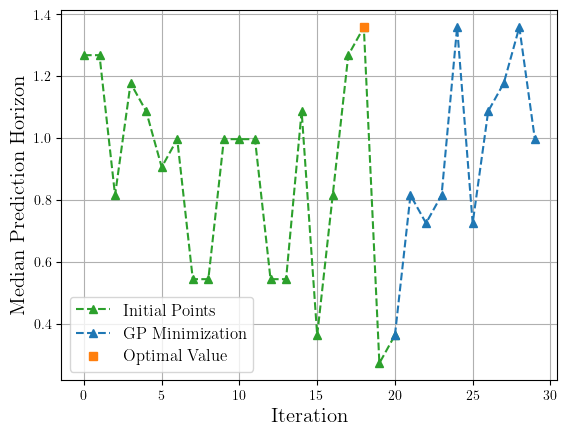

In [50]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.plot(
        -func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.plot(
    xplot,
    -func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.plot([optim_idx], [-func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Median Prediction Horizon', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/median_PH.pdf', bbox_inches='tight', dpi=300)
plt.show()

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

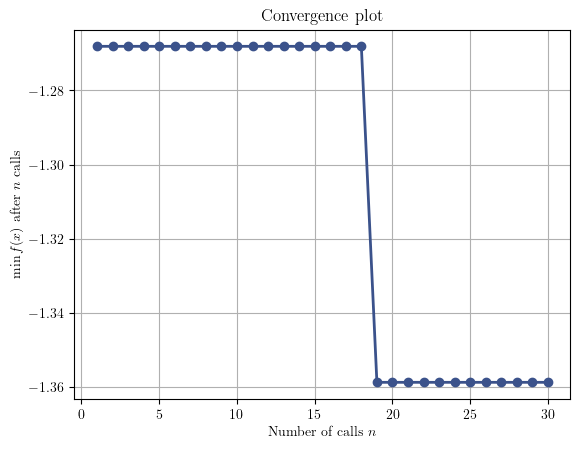

In [51]:
from skopt.plots import plot_convergence
plot_convergence(res)

In [52]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_rnn+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_rnn+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

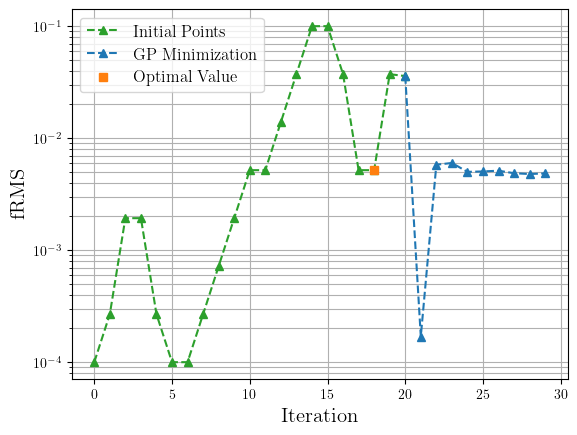

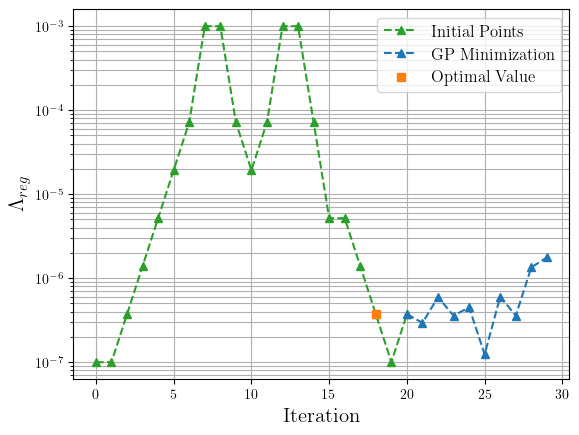

In [53]:
xoptim_names = [
    [r'fRMS', 'fRMS', plt.semilogy],
    [r'$\Lambda_{reg}$', 'lambda_reg', plt.semilogy],
]
if vary_zoneout == True:
    xoptim_names.append(
        [r'$p^{zoneout}$', 'zoneout', plt.plot]
    )

for i in range(len(xoptim_names)):
    a = n_initial_points + len(x0)
    # sorted_idx = np.argsort(x_iters[a:, 0])

    xplot = np.arange(x_iters.shape[0])
    if a > 0:
        xoptim_names[i][2](
            x_iters[:, i][0:a+1],
            linestyle='--',
            color='C2',
            marker='^',
            label='Initial Points',
        )
        xplot = np.arange(a, x_iters.shape[0])
    xoptim_names[i][2](
        xplot,
        x_iters[:, i][a:],
        linestyle='--',
        marker='^',
        label='GP Minimization',#'__nolegend__',
    )
    xoptim_names[i][2]([optim_idx], [x_iters[optim_idx, i]], 's', label='Optimal Value')

    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel(xoptim_names[i][0], fontsize=15)
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='both', axis='y')
    plt.legend(fontsize=12)

    plt.savefig(dir_name_rnn_plots+'/'+xoptim_names[i][1]+'.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [54]:
dir_list = os.listdir(dir_name_rnn+'/tested_rnn')
# dir_list

In [55]:
ph_mean_lst = []
for dir_name in dir_list:
    with np.load(dir_name_rnn+'/tested_rnn/'+dir_name+'/prediction_horizons-testingdata--combinedAERNN--ZEROoutsteps.npz') as f:
        ph_mean = np.mean(f['prediction_horizon_arr'])
        ph_mean_lst.append(ph_mean)
ph_mean_lst = np.array(ph_mean_lst)

In [56]:
idx = np.where(ph_mean_lst == ph_mean_lst.max())[0]

In [57]:
idx, dir_list[idx[0]]

(array([25]), 'test_rnn_028')

In [58]:
# convergence plot
convergence_f = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_f[i] = min_val

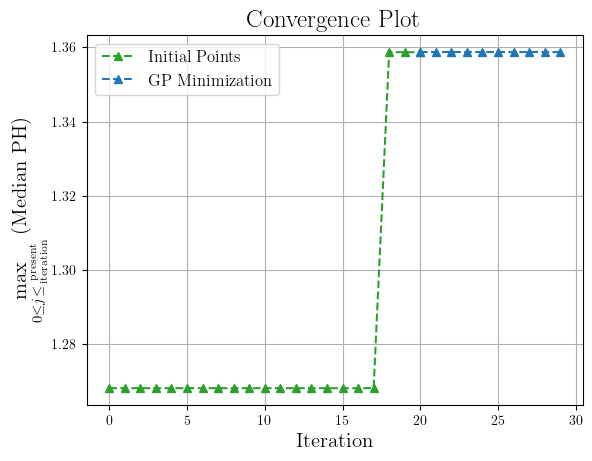

In [59]:
a = n_initial_points + len(x0)
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.plot(
        -convergence_f[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.plot(
    xplot,
    -convergence_f[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
#     r"$$\min_{0 \leq j \leq \mathrm{present \ iteration}} \left( \mathrm{Test \ MSE} \right)$$",
#     r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    r"$$\max_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Median \ PH} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_rnn_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Prediction horizon computation